# Modal organization in Chinese Folks songs
-----------
## Digital Musicology - Milestone 3
-------

In [51]:
# Imports 

from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import math
from fractions import Fraction

In [284]:
def string_to_float_list(string_list):
    try:
        return [float(x) for x in string_list.replace("[", "").replace("]", "").replace(" ","").split(",")]
    except:
        return None

In [285]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval, 'intervals':eval, 'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.beat_strengths = CFS_full.beat_strengths.apply(string_to_float_list)
CFS_full.durations = CFS_full.durations.apply(string_to_float_list)
print(len(CFS_full))
CFS_full = CFS_full.dropna()
print(len(CFS_full))
CFS_full.head()

2193
1903


,region,title,location,tonic,pitches,pitchclasses,durations,beat_strengths,intervals,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...","[D, A, C, D, D, A, C, D, G, C, A, G, A, C, D, ...","[1.0, 0.5, 0.5, 1.0, 1.0, 0.75, 0.25, 0.5, 0.5...","[1.0, 0.5, 0.25, 1.0, 0.5, 1.0, 0.125, 0.5, 0....","[P4, m3, M2, P1, P4, m3, M2, P4, P5, m3, M2, M...","[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, C, C, G, B-, C, F, B-, G, F, G, B-,...","[C, B-, F, G, D]",shang,Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...","[D, A, D, D, A, D, A, D, G, E, D, D, D, G, G, ...","[1.0, 1.0, 0.5, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, ...","[1.0, 0.5, 1.0, 0.25, 0.5, 1.0, 0.25, 0.5, 1.0...","[P4, P4, P1, P4, P4, P4, P4, P5, m3, M2, P1, P...","[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, C, C, G, C, G, C, F, D, C, C, C, F, F, ...","[C, G, F, D, A]",zhi,Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...","[E-, C, B-, A-, B-, E-, F, E-, C, B-, A-, A-, ...","[0.75, 0.25, 0.5, 0.5, 0.5, 0.5, 1.0, 0.75, 0....","[1.0, 0.125, 0.5, 0.25, 1.0, 0.25, 0.5, 1.0, 0...","[m3, M2, M2, M2, P5, M2, m7, m3, M2, M2, P1, M...","[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, C, F, G, F, D, C, B-, B-, C, F, ...","[C, F, G, B-, D]",shang,Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...","[E, E, A, G, A, B, E, D, E, B, E, E, A, G, A, ...","[1.0, 1.0, 0.5, 0.25, 0.25, 1.0, 1.0, 0.5, 0.5...","[1.0, 0.5, 1.0, 0.25, 0.125, 0.5, 1.0, 0.5, 0....","[P1, P4, M2, M2, M2, P4, M2, M2, P4, P4, P1, P...","[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, C, F, E-, F, G, C, B-, C, G, C, C, F, E-, ...","[C, G, F, B-, E-]",yu,Northwest
5,han,Yi gan hongqi kongzhong piao,"Asia, China, Shanxi Shanbei",D,"[C5, D5, G5, D5, E5, D5, C5, A4, C5, A4, G4, D...","[C, D, G, D, E, D, C, A, C, A, G, D, C, C, D, ...","[0.5, 1.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.5, 0.5...","[1.0, 0.25, 1.0, 0.25, 0.5, 0.125, 0.25, 1.0, ...","[M2, P4, P4, M2, M2, M2, m3, m3, m3, M2, P4, m...","[B-4, C5, F5, C5, D5, C5, B-4, G4, B-4, G4, F4...","[B-, C, F, C, D, C, B-, G, B-, G, F, C, B-, B-...","[C, B-, G, F, D]",shang,Northwest


## Exploring regional differences

In [94]:
pitch_classes_list = ['A', 'A#', 'A-', 'B', 'B#', 'B-', 'C', 'C#', 'C-', 'D', 'D#', 'D-', 'E', 'E#', 'E-', 'F', 'F#', 'G', 'G#', 'G-']
music_interval_list = ['A1','A2','A3','A4','A5','A6','A7','P1','P4','P5','P8','m2','M2','m3','M3','m6','M6','m7','M7',"d2","d3","d4","d5","d6","d7","d8"]

pitchclasses_defcount = {pc:0 for pc in pitch_classes_list}
pitchclasses_transitions_defcount = {pc1:{pc2:0 for pc2 in pitch_classes_list} for pc1 in pitch_classes_list}
intervals_defcount = {pc:0 for pc in music_interval_list}

### Pitch statistics (without metrical information)

In this subsection, we plot the combined pitch and scale degrees distributions of all the pieces combined for each division.

To do so, we first create empty dictionaries to store the pitches and scale degrees before and after transposition with division name as key and values as a list of pitches/scale degrees of all pieces belonging to that division.

In [175]:
# Empty dictionaries to store pitches and 
region_pitch_stat = {}
region_pitch_classes_stat = {}
region_pitch_transposed_stat = {}
region_scaledegrees_stat = {}
region_tonic_stat = {}
region_intervals_stat = {}
region_durations_stat = {}
region_beat_strengths_stat = {}

for gloc in geo_divisions: 
    region_df = CFS_full[CFS_full["geo_division"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_pitch_classes_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_scaledegrees_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])
    region_tonic_stat[gloc] = region_df["tonic"].tolist()
    region_intervals_stat[gloc] = sum(region_df["intervals"].tolist(), [])
    region_durations_stat[gloc] = sum(region_df["durations"].tolist(), [])
    region_beat_strengths_stat[gloc] = sum(region_df["beat_strengths"].tolist(), [])

In [255]:
def plot_region_stat_counts(stat, defcount=None, figsize=(20,10), nrows=2, ncols=4, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols)

    for gloc,ax in zip(stat, axarr.flat):
        counter = Counter(stat[gloc])
        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        ax.bar(x, y, color='black')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc))

In [256]:
def plot_region_stat_met(stat, defcount=None, figsize=(20,10), nrows=2, ncols=4, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols)

    for gloc ,ax in zip(stat, axarr.flat):

        counter = {}
        for i in range(len(stat[gloc])):
            if math.isnan(region_beat_strengths_stat[gloc][i]) or math.isnan(region_durations_stat[gloc][i]):
                continue
            if not stat[gloc][i] in counter.keys():
                counter[stat[gloc][i]] = region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]
            else:
                counter[stat[gloc][i]] +=  region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]

        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        ax.bar(x, y, color='black')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc))

The pitch distribution can then be computed by counting the occurrence of each pitch. This distribution can then be shown with a bar plot.

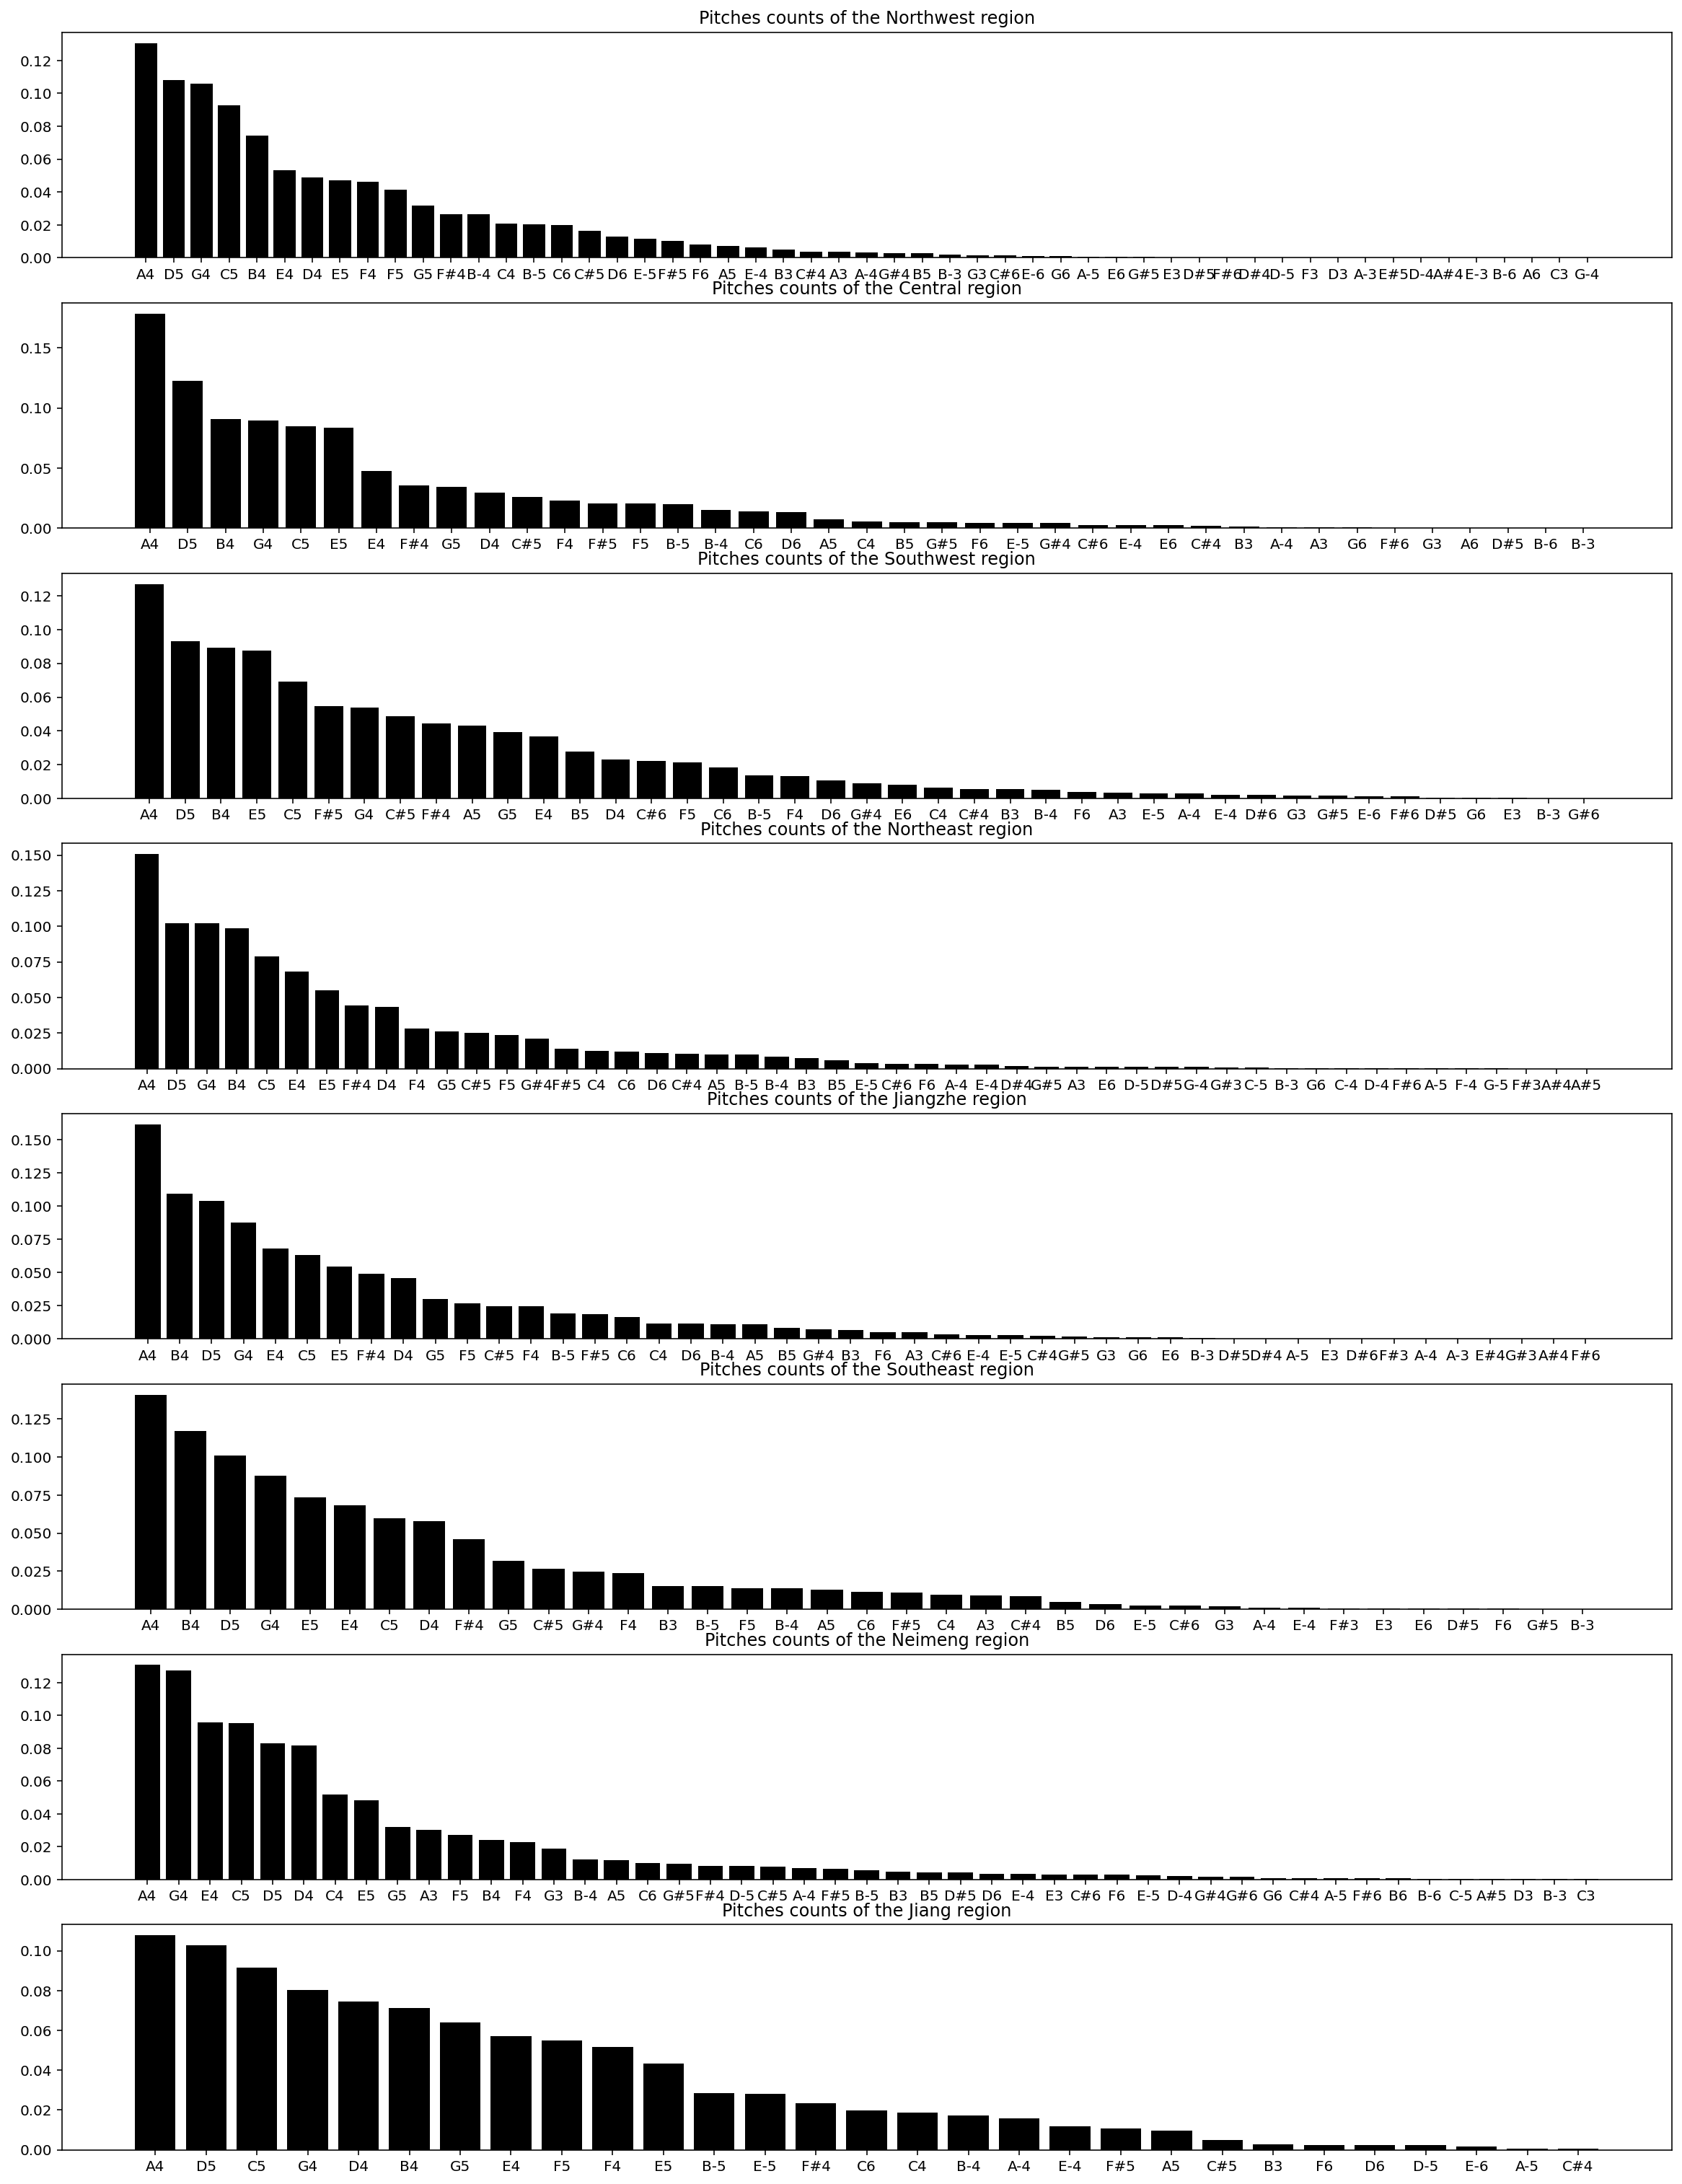

In [261]:
plot_region_stat_counts(region_pitch_stat, figsize=(20,27), nrows=len(region_pitch_stat), ncols=1, title="Pitches counts of the {} region")

By comparing each of these plots, we can get a first comparison of the pieces of each region. The first striking observation is that these distributions look similar across the regions. Indeed, we notice that A4, B4, C5, D5, and G4 are dominant in most regions. However, we can also observe differences. For instance, B4 is barely used in the Neimeng region compared to all the other ones.

These remarks give some first insight to our hypothesis: on average, there is no striking difference in the use of pitches across different regions of China. However, further analysis is required to determine the implications of the fluctuations.

### Pitch classes statistics (without metrical information)
In the previous subsection, we compared the use of pitches across regions. As an additional comparison, we now plot the distribution of scale degrees across regions.

For this visualization, we decided to sort the pitch classes by occurrences rather than alphabetically.

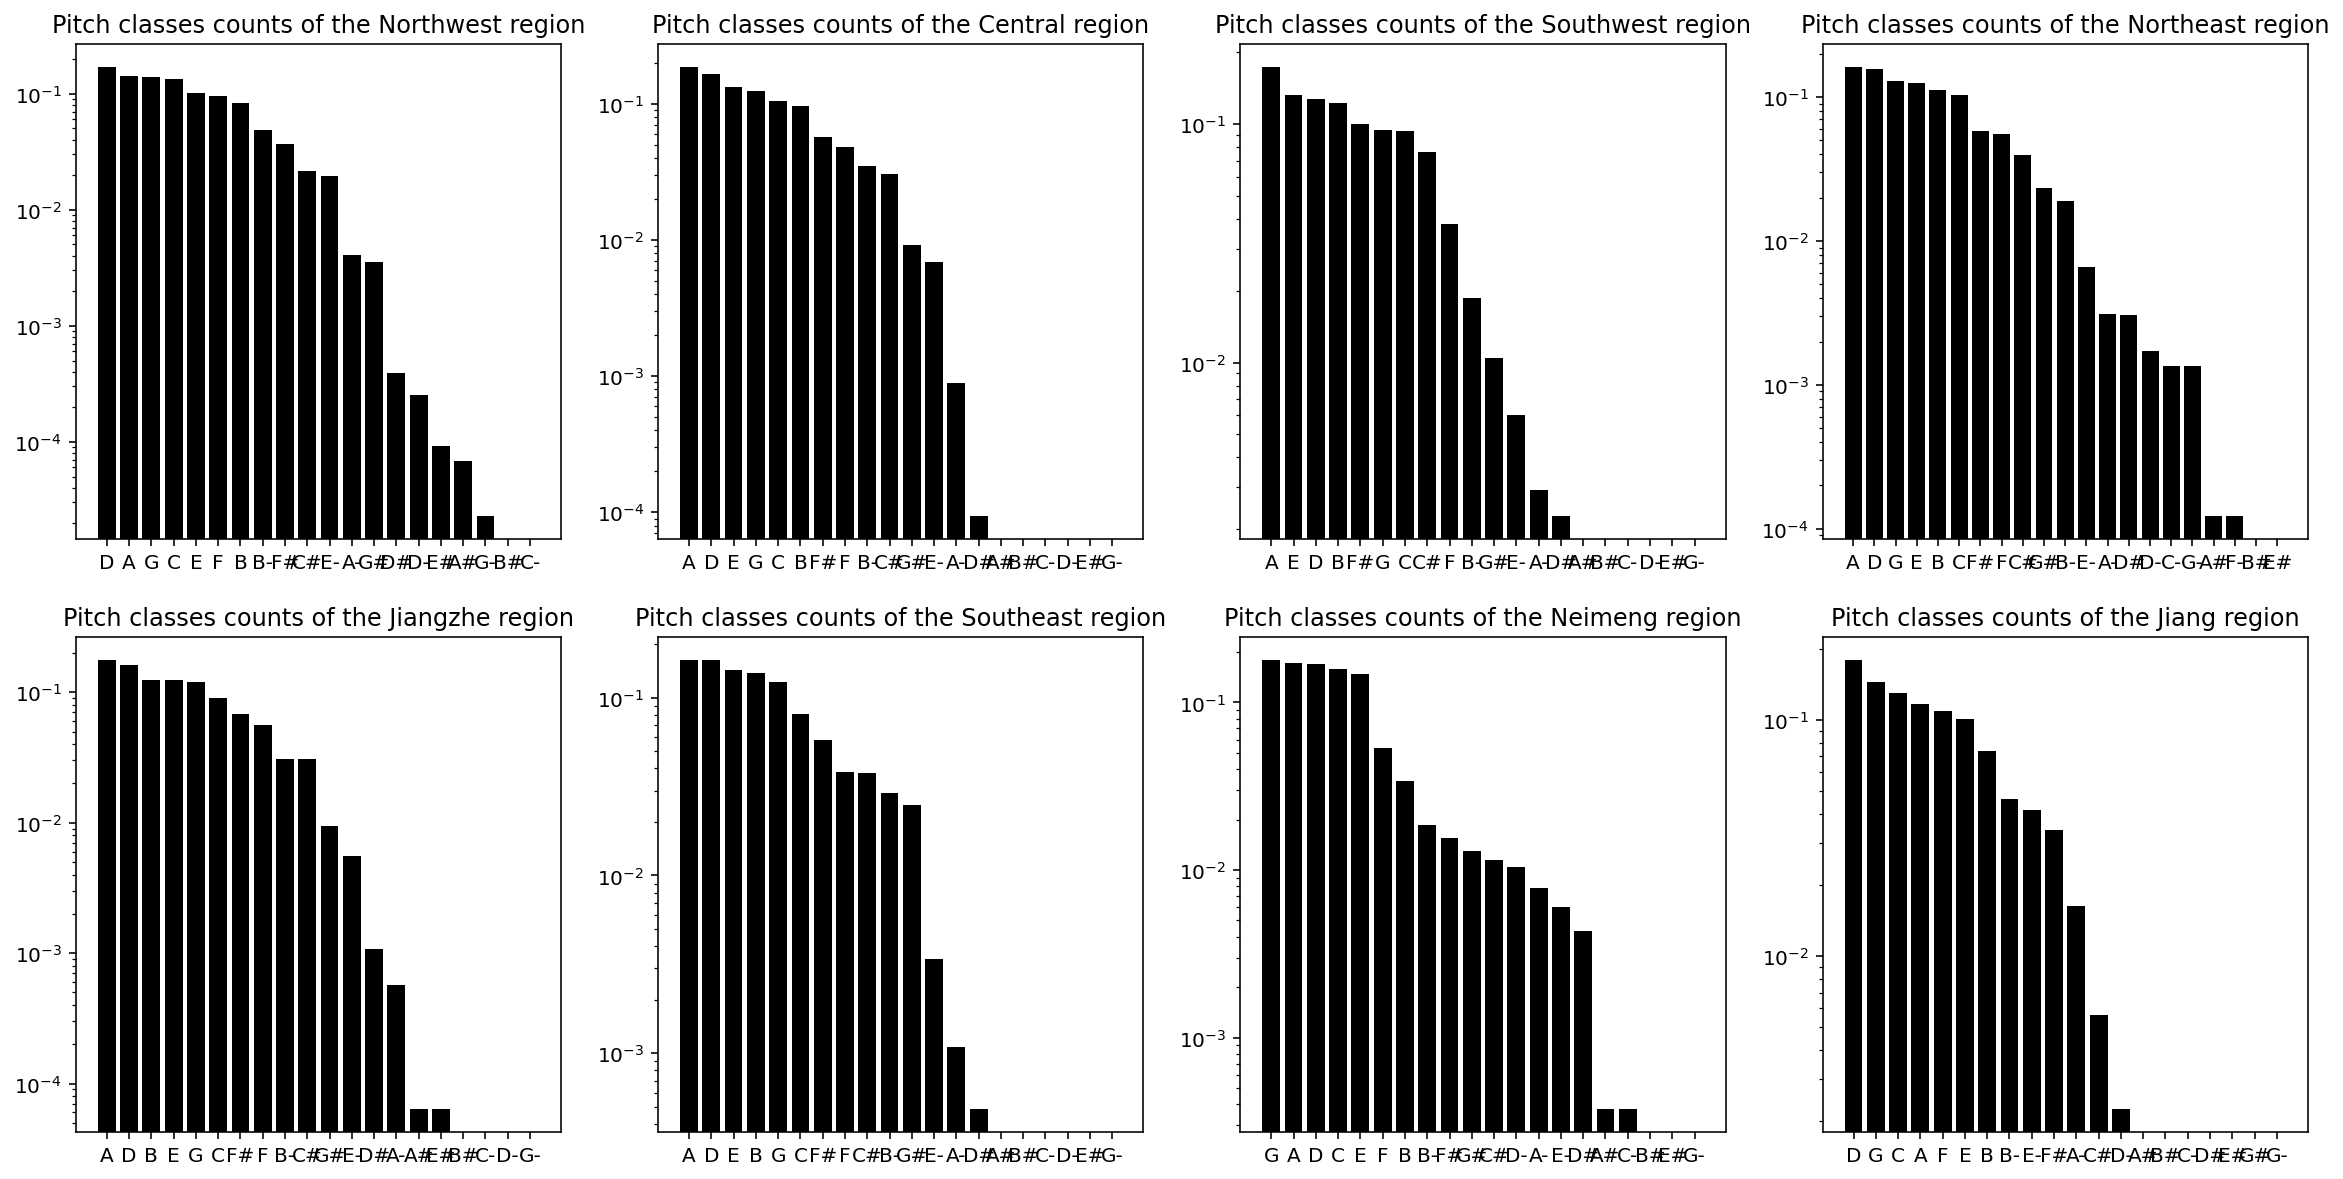

In [260]:
plot_region_stat_counts(region_pitch_classes_stat, pitchclasses_defcount, log_y=True, title="Pitch classes counts of the {} region")

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

A visual comparison of these plots again reveals a great similarity between all regions as `A`, `D` and `E` most often closely compete for the three most used pitch classes. However, we notice once again a significant difference in the Neimeng region, where there is a drop after the 5 most used pitch classes.

These results once again go against our hypothesis. However, the singular example of the Neimeng region must be remembered for the rest of the analysis.

### Scale degrees statistics (without metrical information)
In our research questions, we were particularly interested in the organization of the piece around the central pitch. For that reason, we transposed all pieces to C relatively to their tonic. Analyzing the pitches of these transposed scores reveals information about the use of scale degrees.

As a first analysis, we plot the distribution of use of scale degrees by simply counting them. Note that for simplicity, instead of labeling the plots with scale degrees, they are simply labeled with their pitch class relative to C. Therefore G is V, D is II, etc...

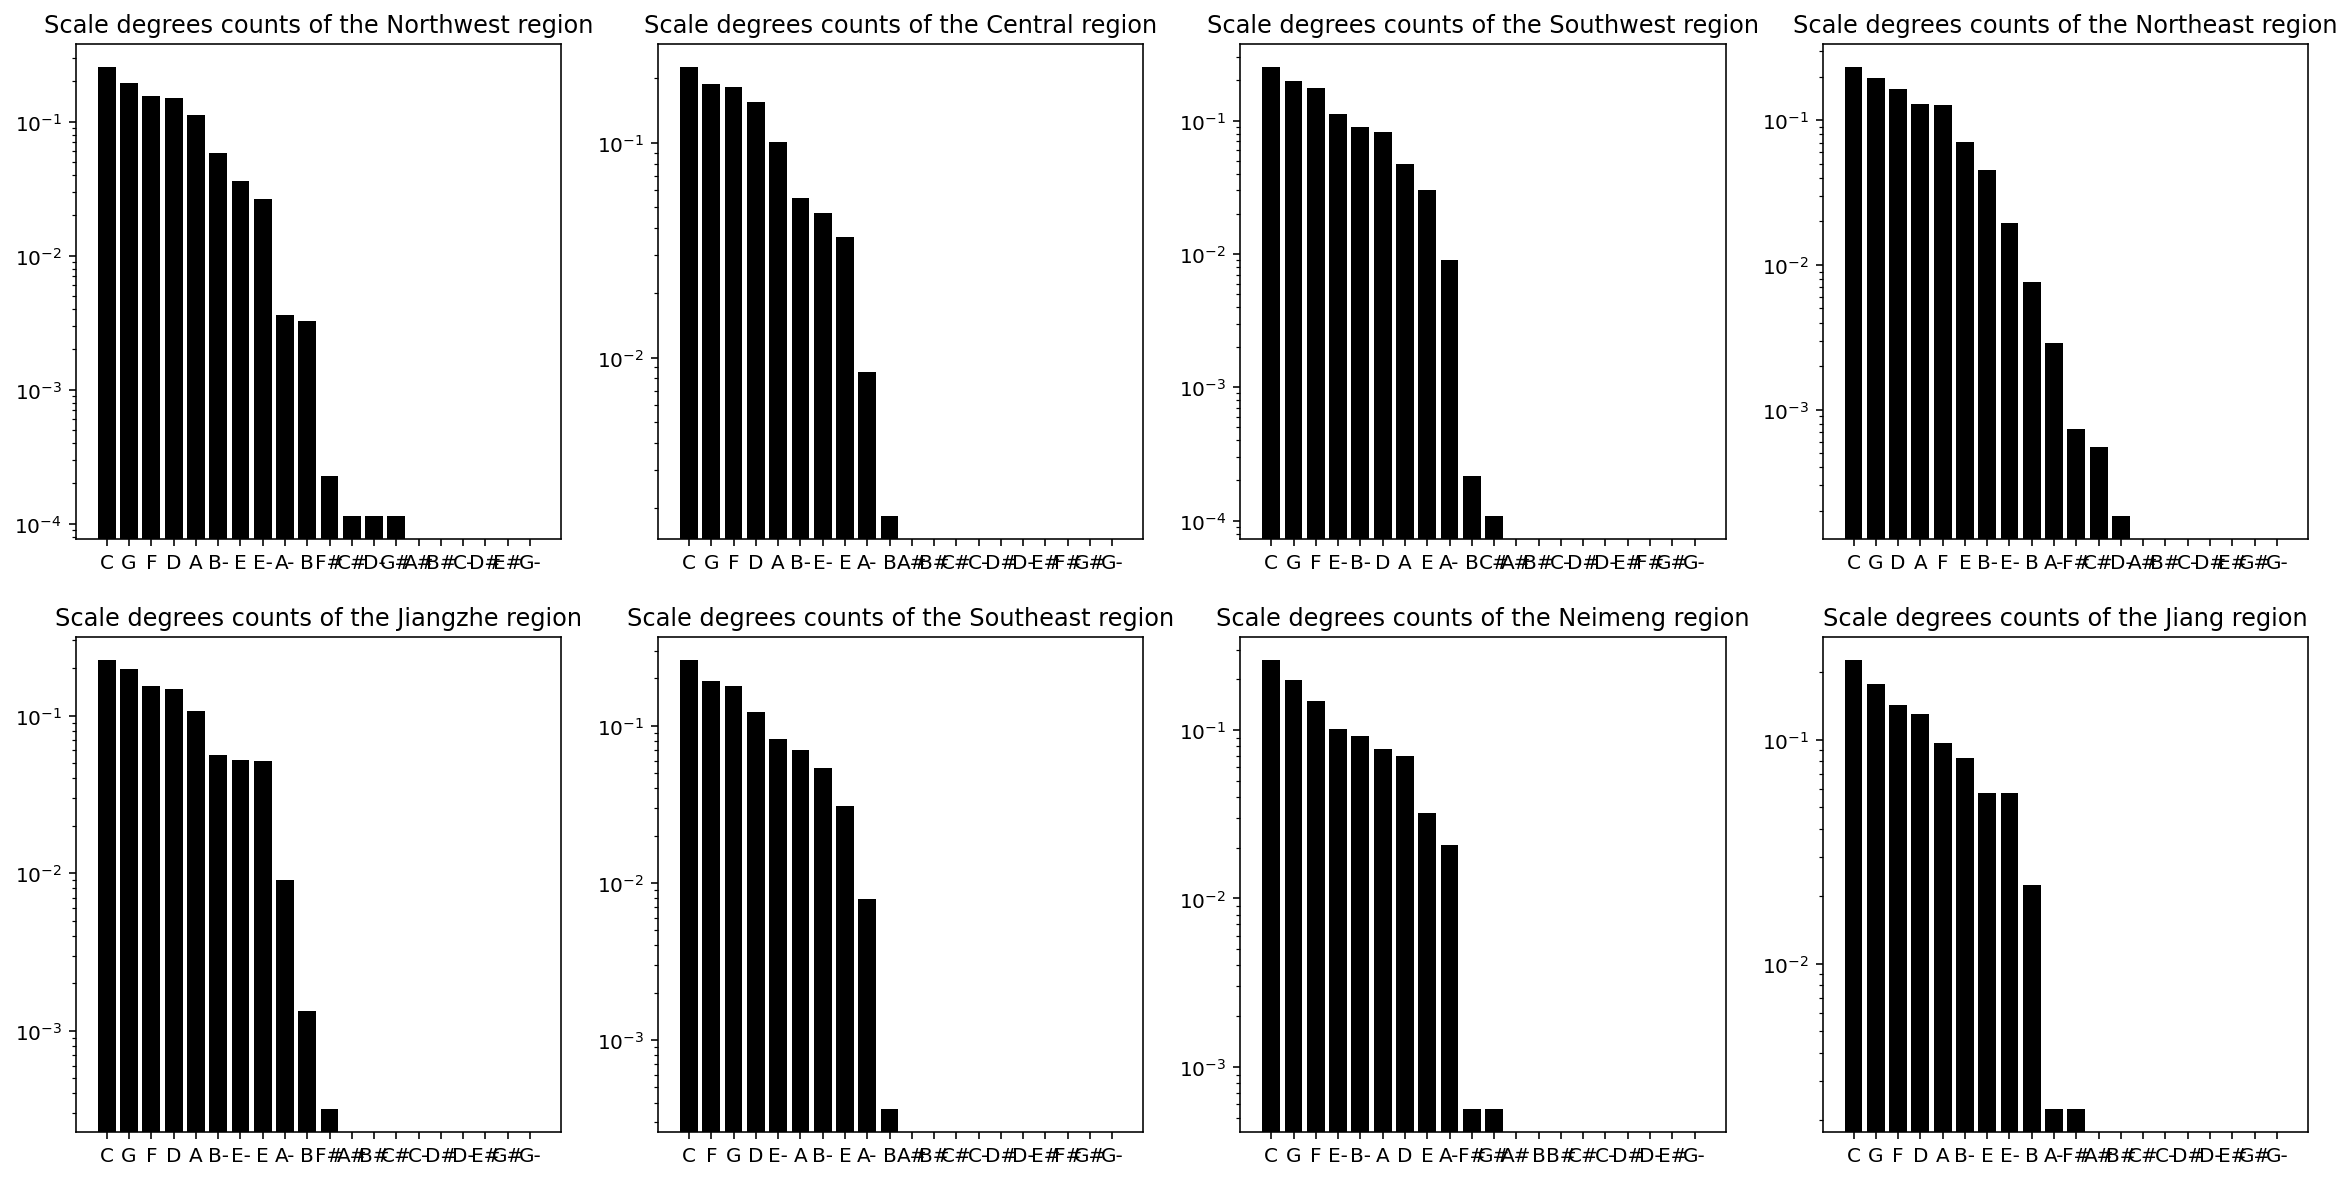

In [262]:
plot_region_stat_counts(region_scaledegrees_stat, pitchclasses_defcount, log_y=True, title="Scale degrees counts of the {} region")

These plots reveal that the distributions of use of scale degrees across regions are vastly similar, thus once again refuting our initial hypothesis. However, it is interesting to note that like in Western music, the fifth and fourth are the most dominant scale degrees.

### Pitch Classes Transitions (without metrical information)

Another means to compare the organization of songs of different divisions is to look at the transitions between the pitches. Comparing these transitions will reveal whether the folks preferred certain pitch transitions to others and may show significant differences across regions.

For this purpose, we create a dictionary to store the count of transitions of the pitch classes in all pieces belonging to one division. The name of the division is the key of the mentioned dictionary and the value is a nested dictionary with keys as the starting pitch class and the values as dictionaries with key as the transitioned pitch class and value as the count of such occurrence.

Now using the pitch class transitions in each division we create a network with pitch class as the nodes and creating an edge in case there is a transition between the nodes. The graph will be directed meaning there exists an edge only in the direction where the pitch transition occurs.

We plot the transitions as heatmaps to help in the interpretation. To create them, we first convert the transition counts from a dictionary to a `DataFrame` and use it to plot the heatmap.

In [100]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for pitchclass in row["pitchclasses"]:
        if prev_pitchclass is not None:
            if prev_pitchclass not in pitchclass_transition[region]:
                pitchclass_transition[region][prev_pitchclass] = {}
            if pitchclass not in  pitchclass_transition[region][prev_pitchclass]:
                pitchclass_transition[region][prev_pitchclass][pitchclass] = 1
            else:
                pitchclass_transition[region][prev_pitchclass][pitchclass] += 1
        prev_pitchclass = pitchclass

In [101]:
def sort_dict(item):
    # function to sort a nested dictionary based on key
    # credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

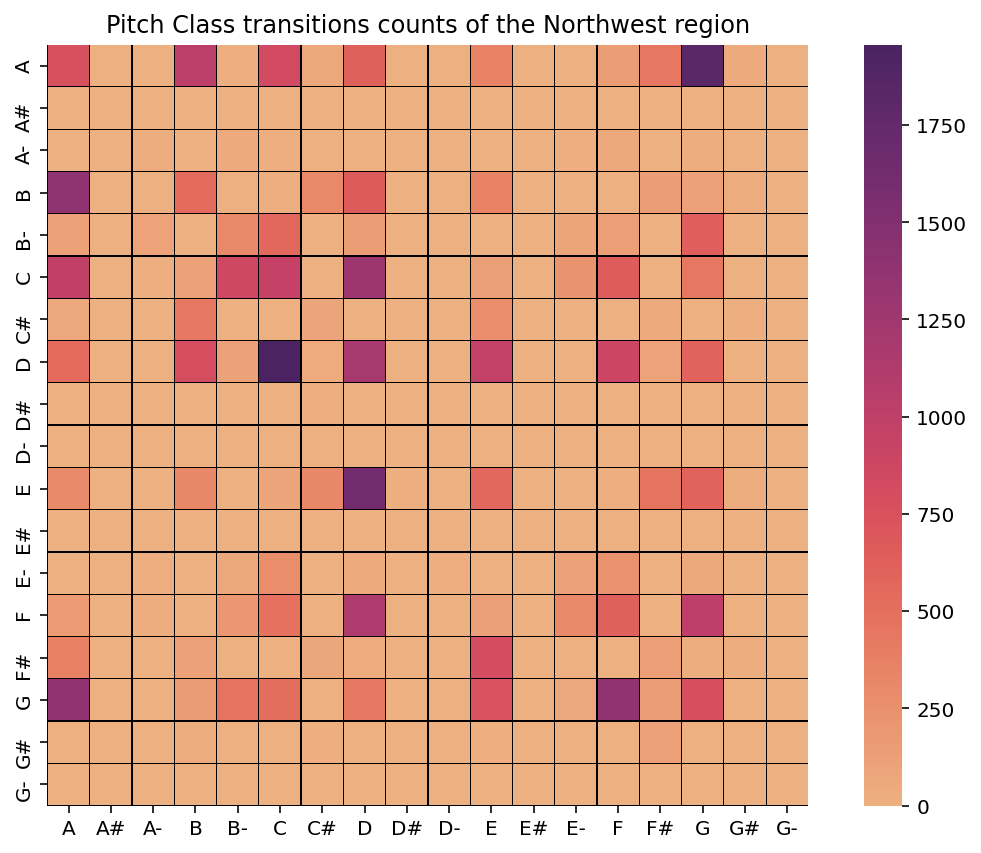

----------------------------------------------------------------------------------------------------


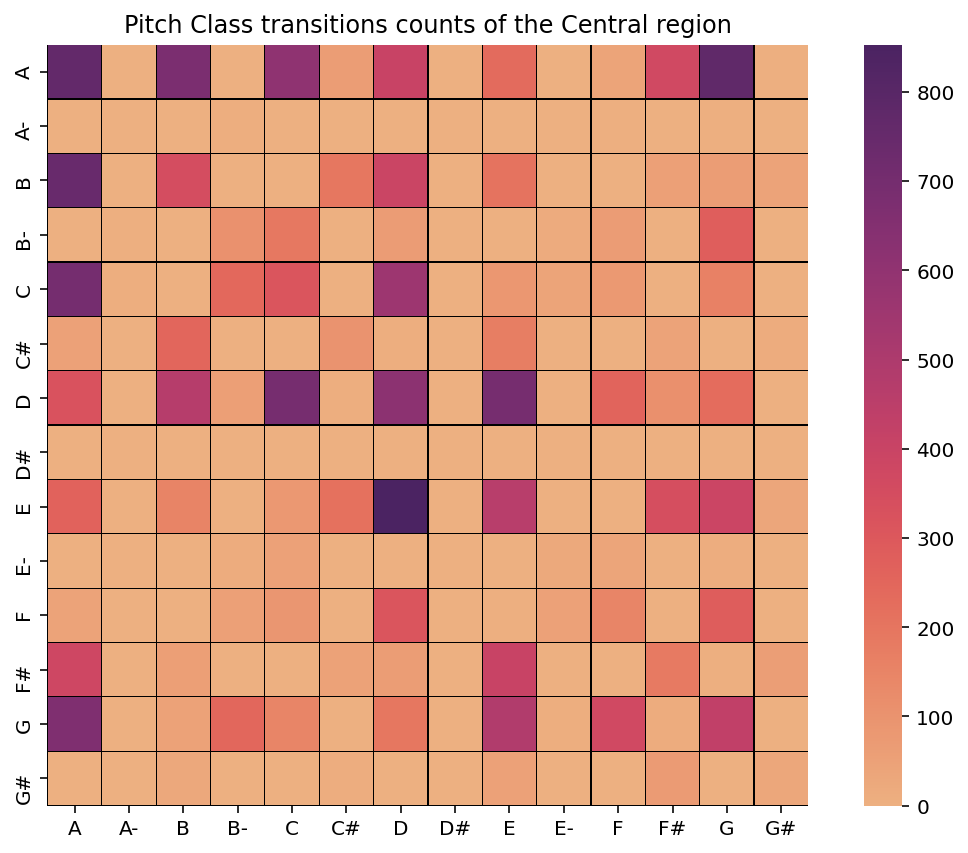

----------------------------------------------------------------------------------------------------


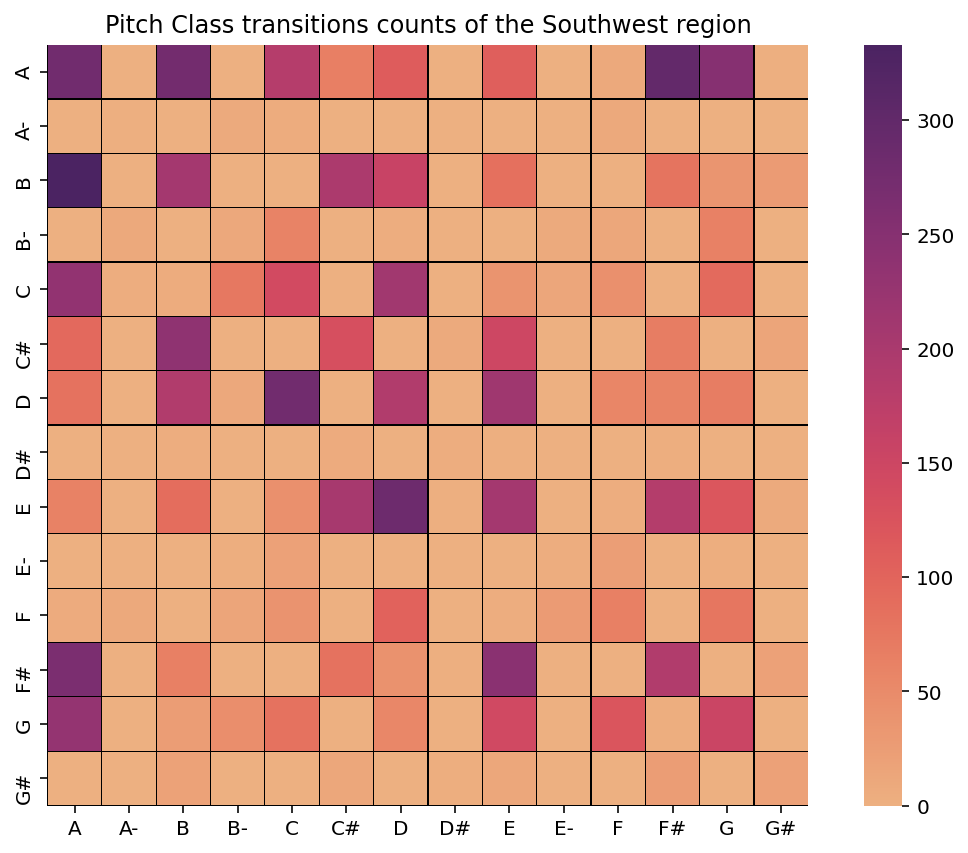

----------------------------------------------------------------------------------------------------


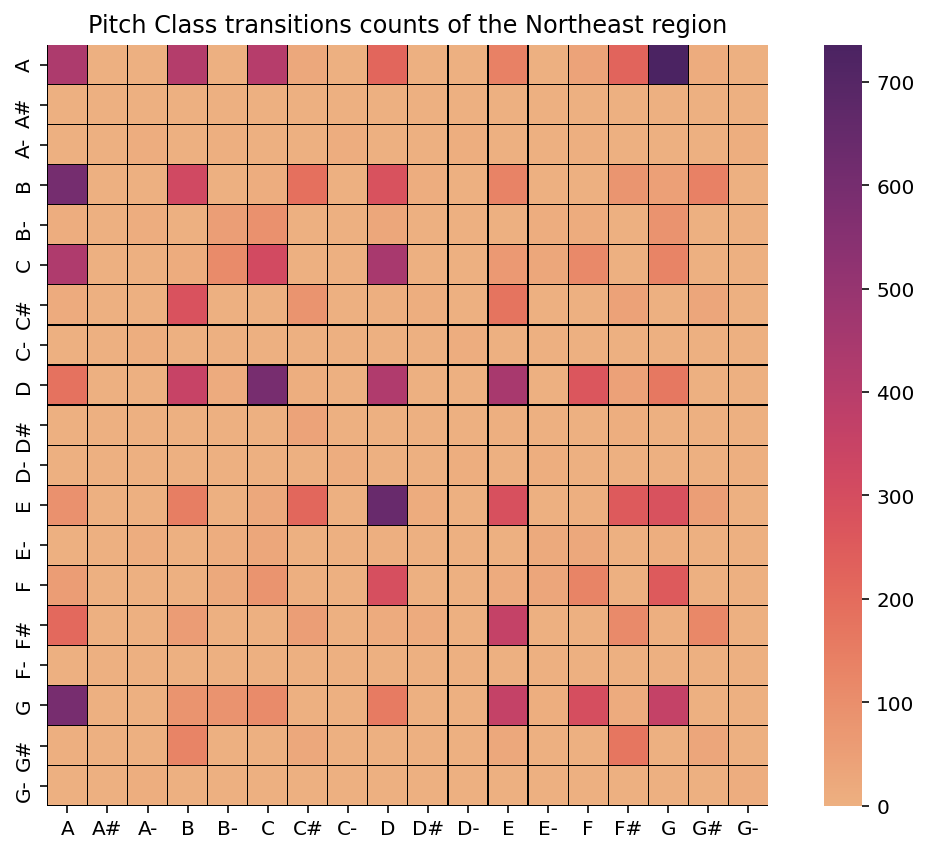

----------------------------------------------------------------------------------------------------


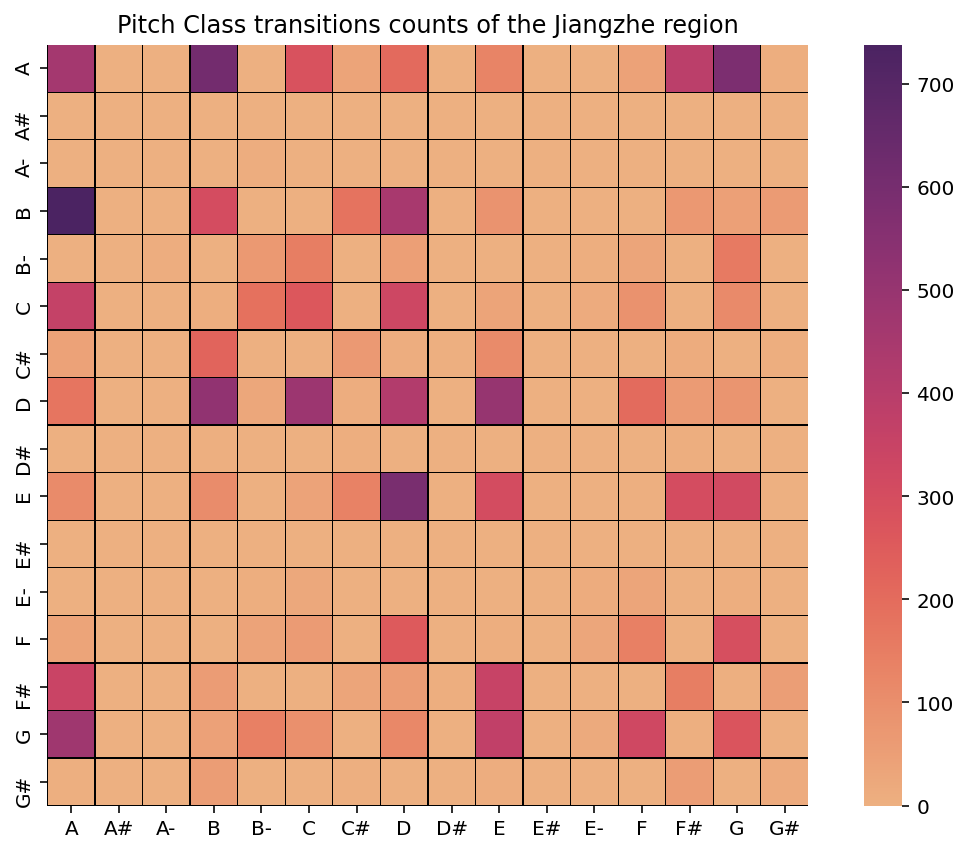

----------------------------------------------------------------------------------------------------


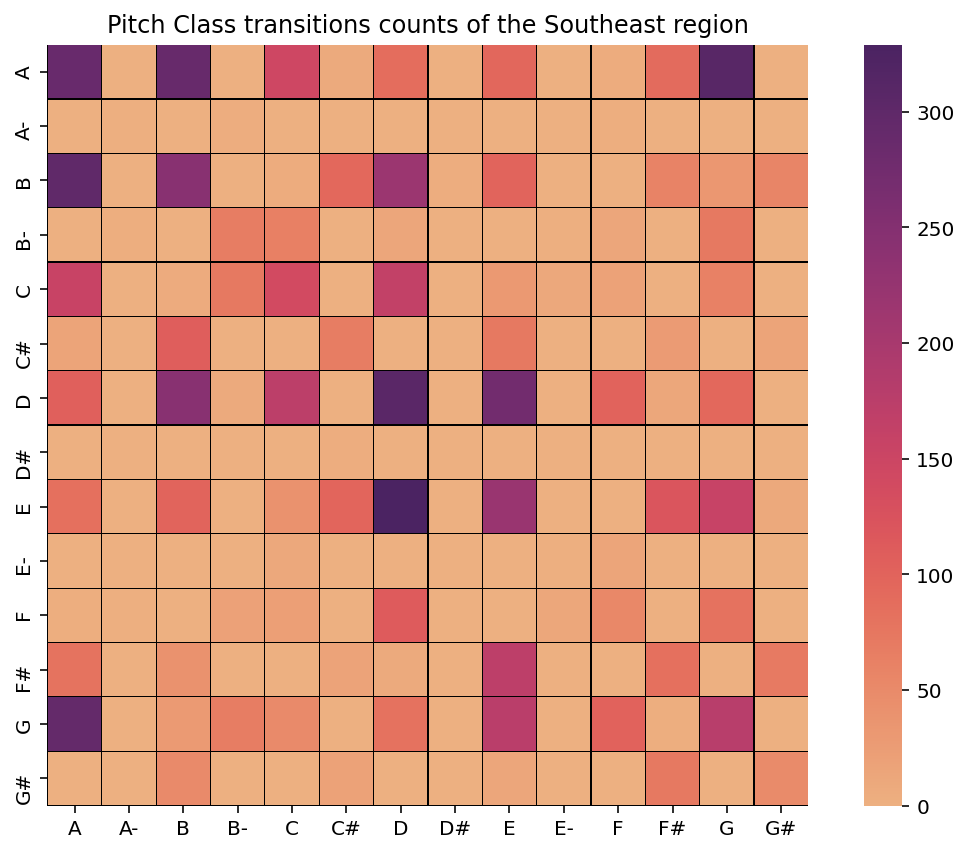

----------------------------------------------------------------------------------------------------


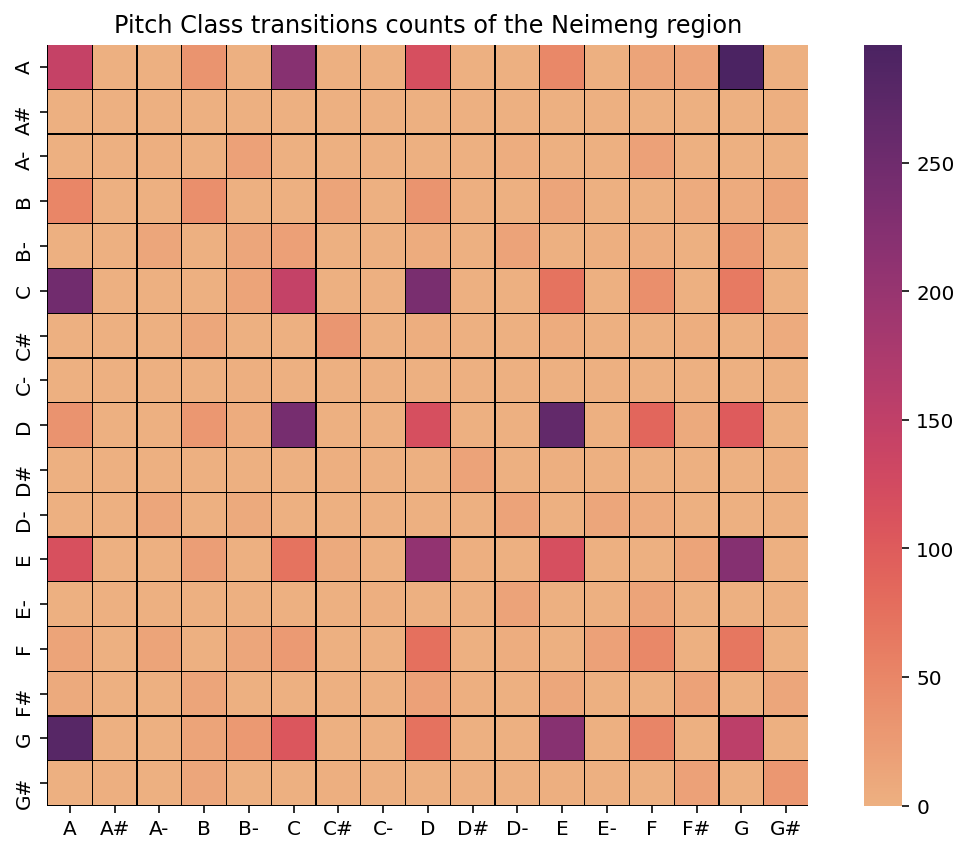

----------------------------------------------------------------------------------------------------


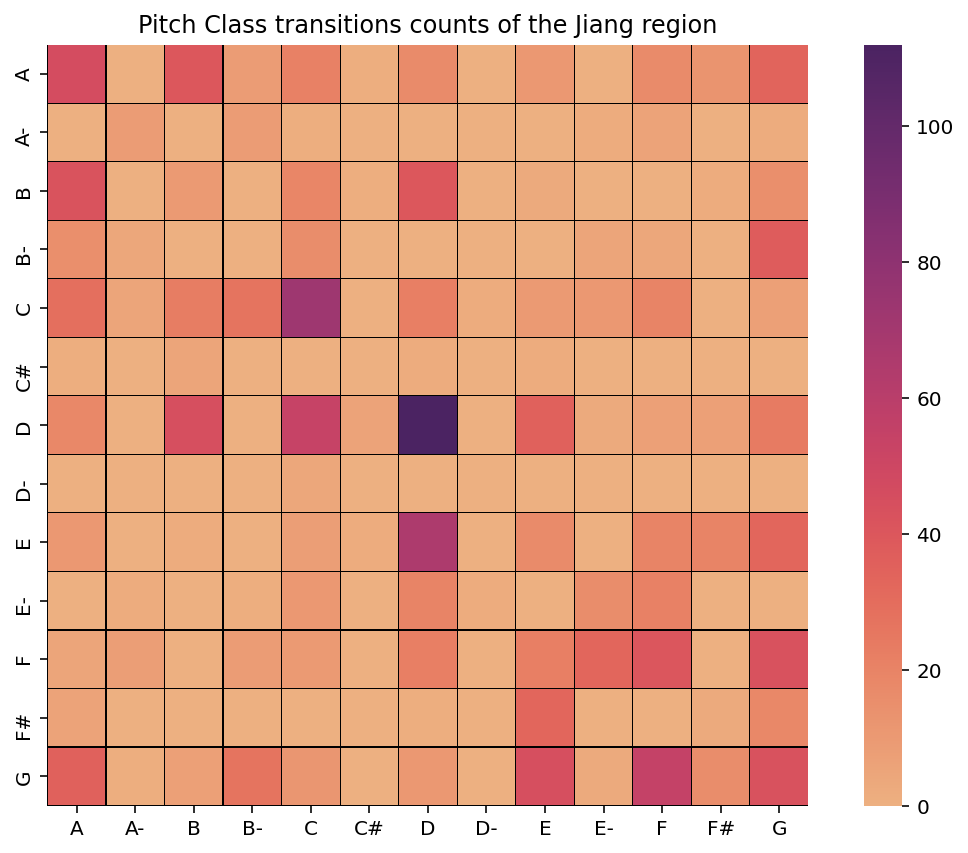

----------------------------------------------------------------------------------------------------


In [263]:
plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transitions counts of the {} region".format(gloc))
    plt.show()
    
    print("--"*50)

### Interval Transitions (without metrical information)

Another means to compare the organization of songs of different divisions is to look at the transitions between the intervals.

For this purpose, we create a dictionary to store the count of transitions of the intervals in all pieces belonging to one division. The name of the division is the key of the mentioned dictionary and the value is the count of such occurrence.

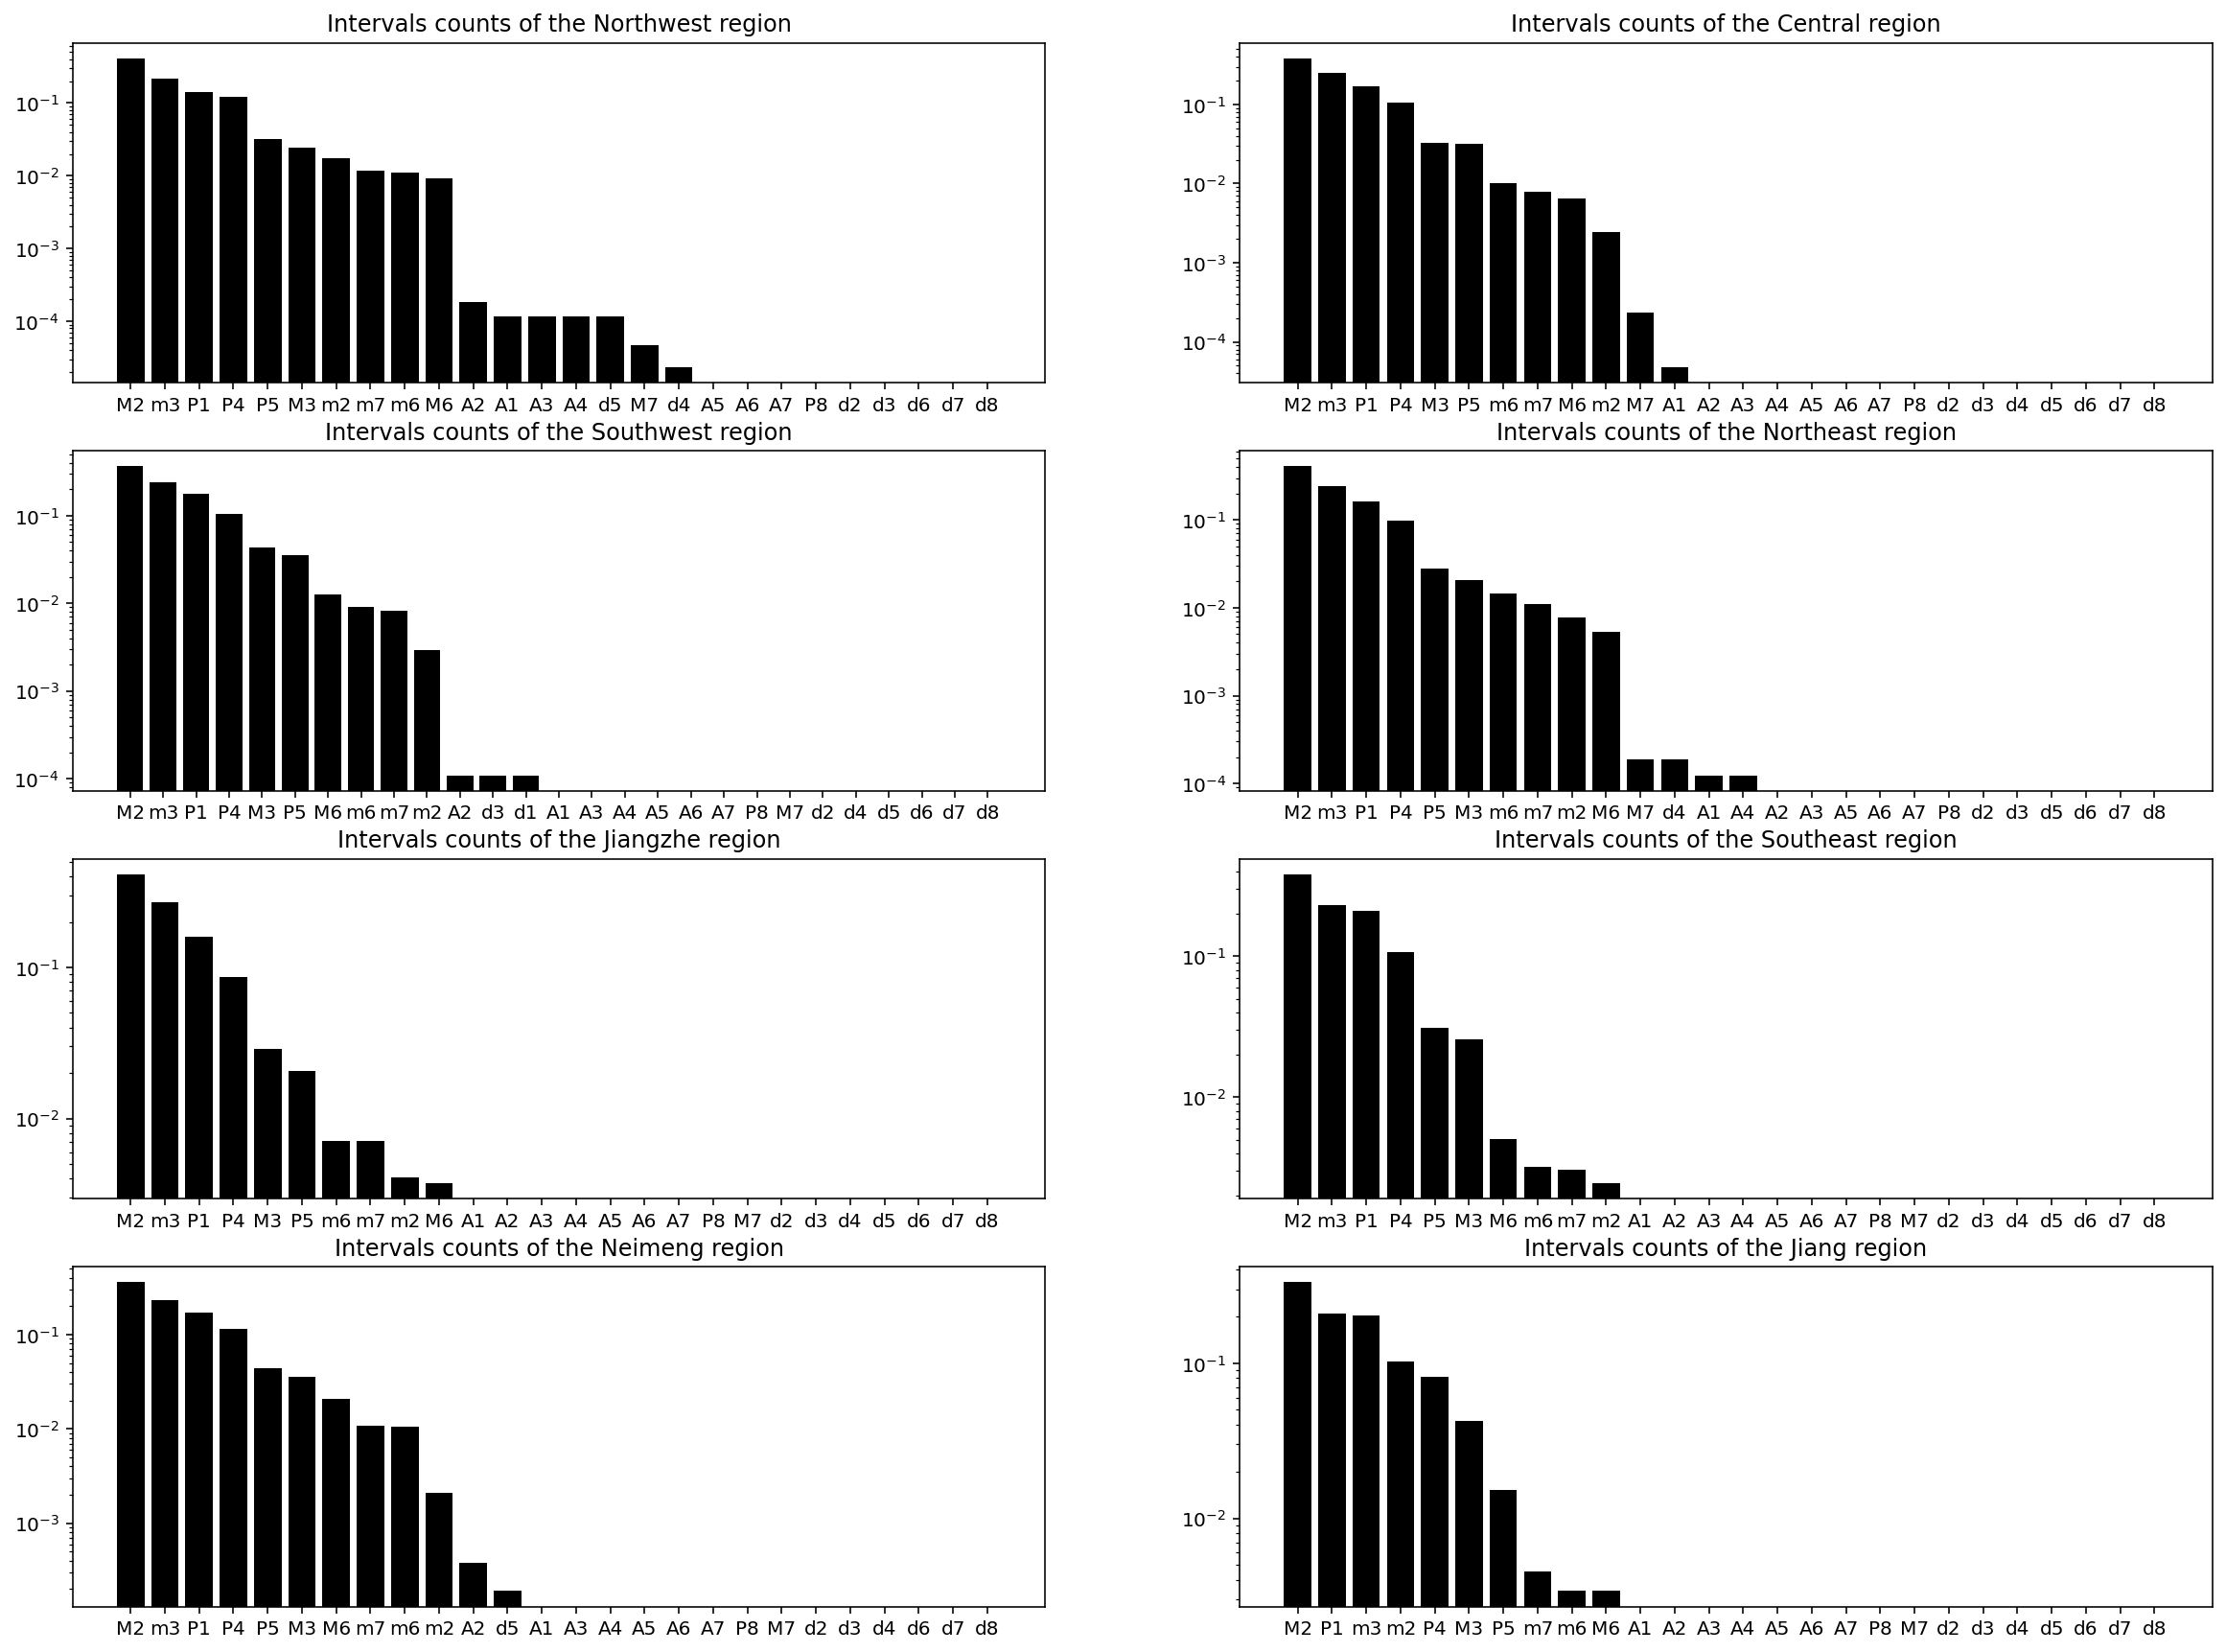

In [264]:
plot_region_stat_counts(region_intervals_stat, intervals_defcount, log_y=True, ncols=2, nrows=4, figsize=(20,15), title="Intervals counts of the {} region")

### Pitch statistics (with metrical information)

For now metrical information is the duration of the note

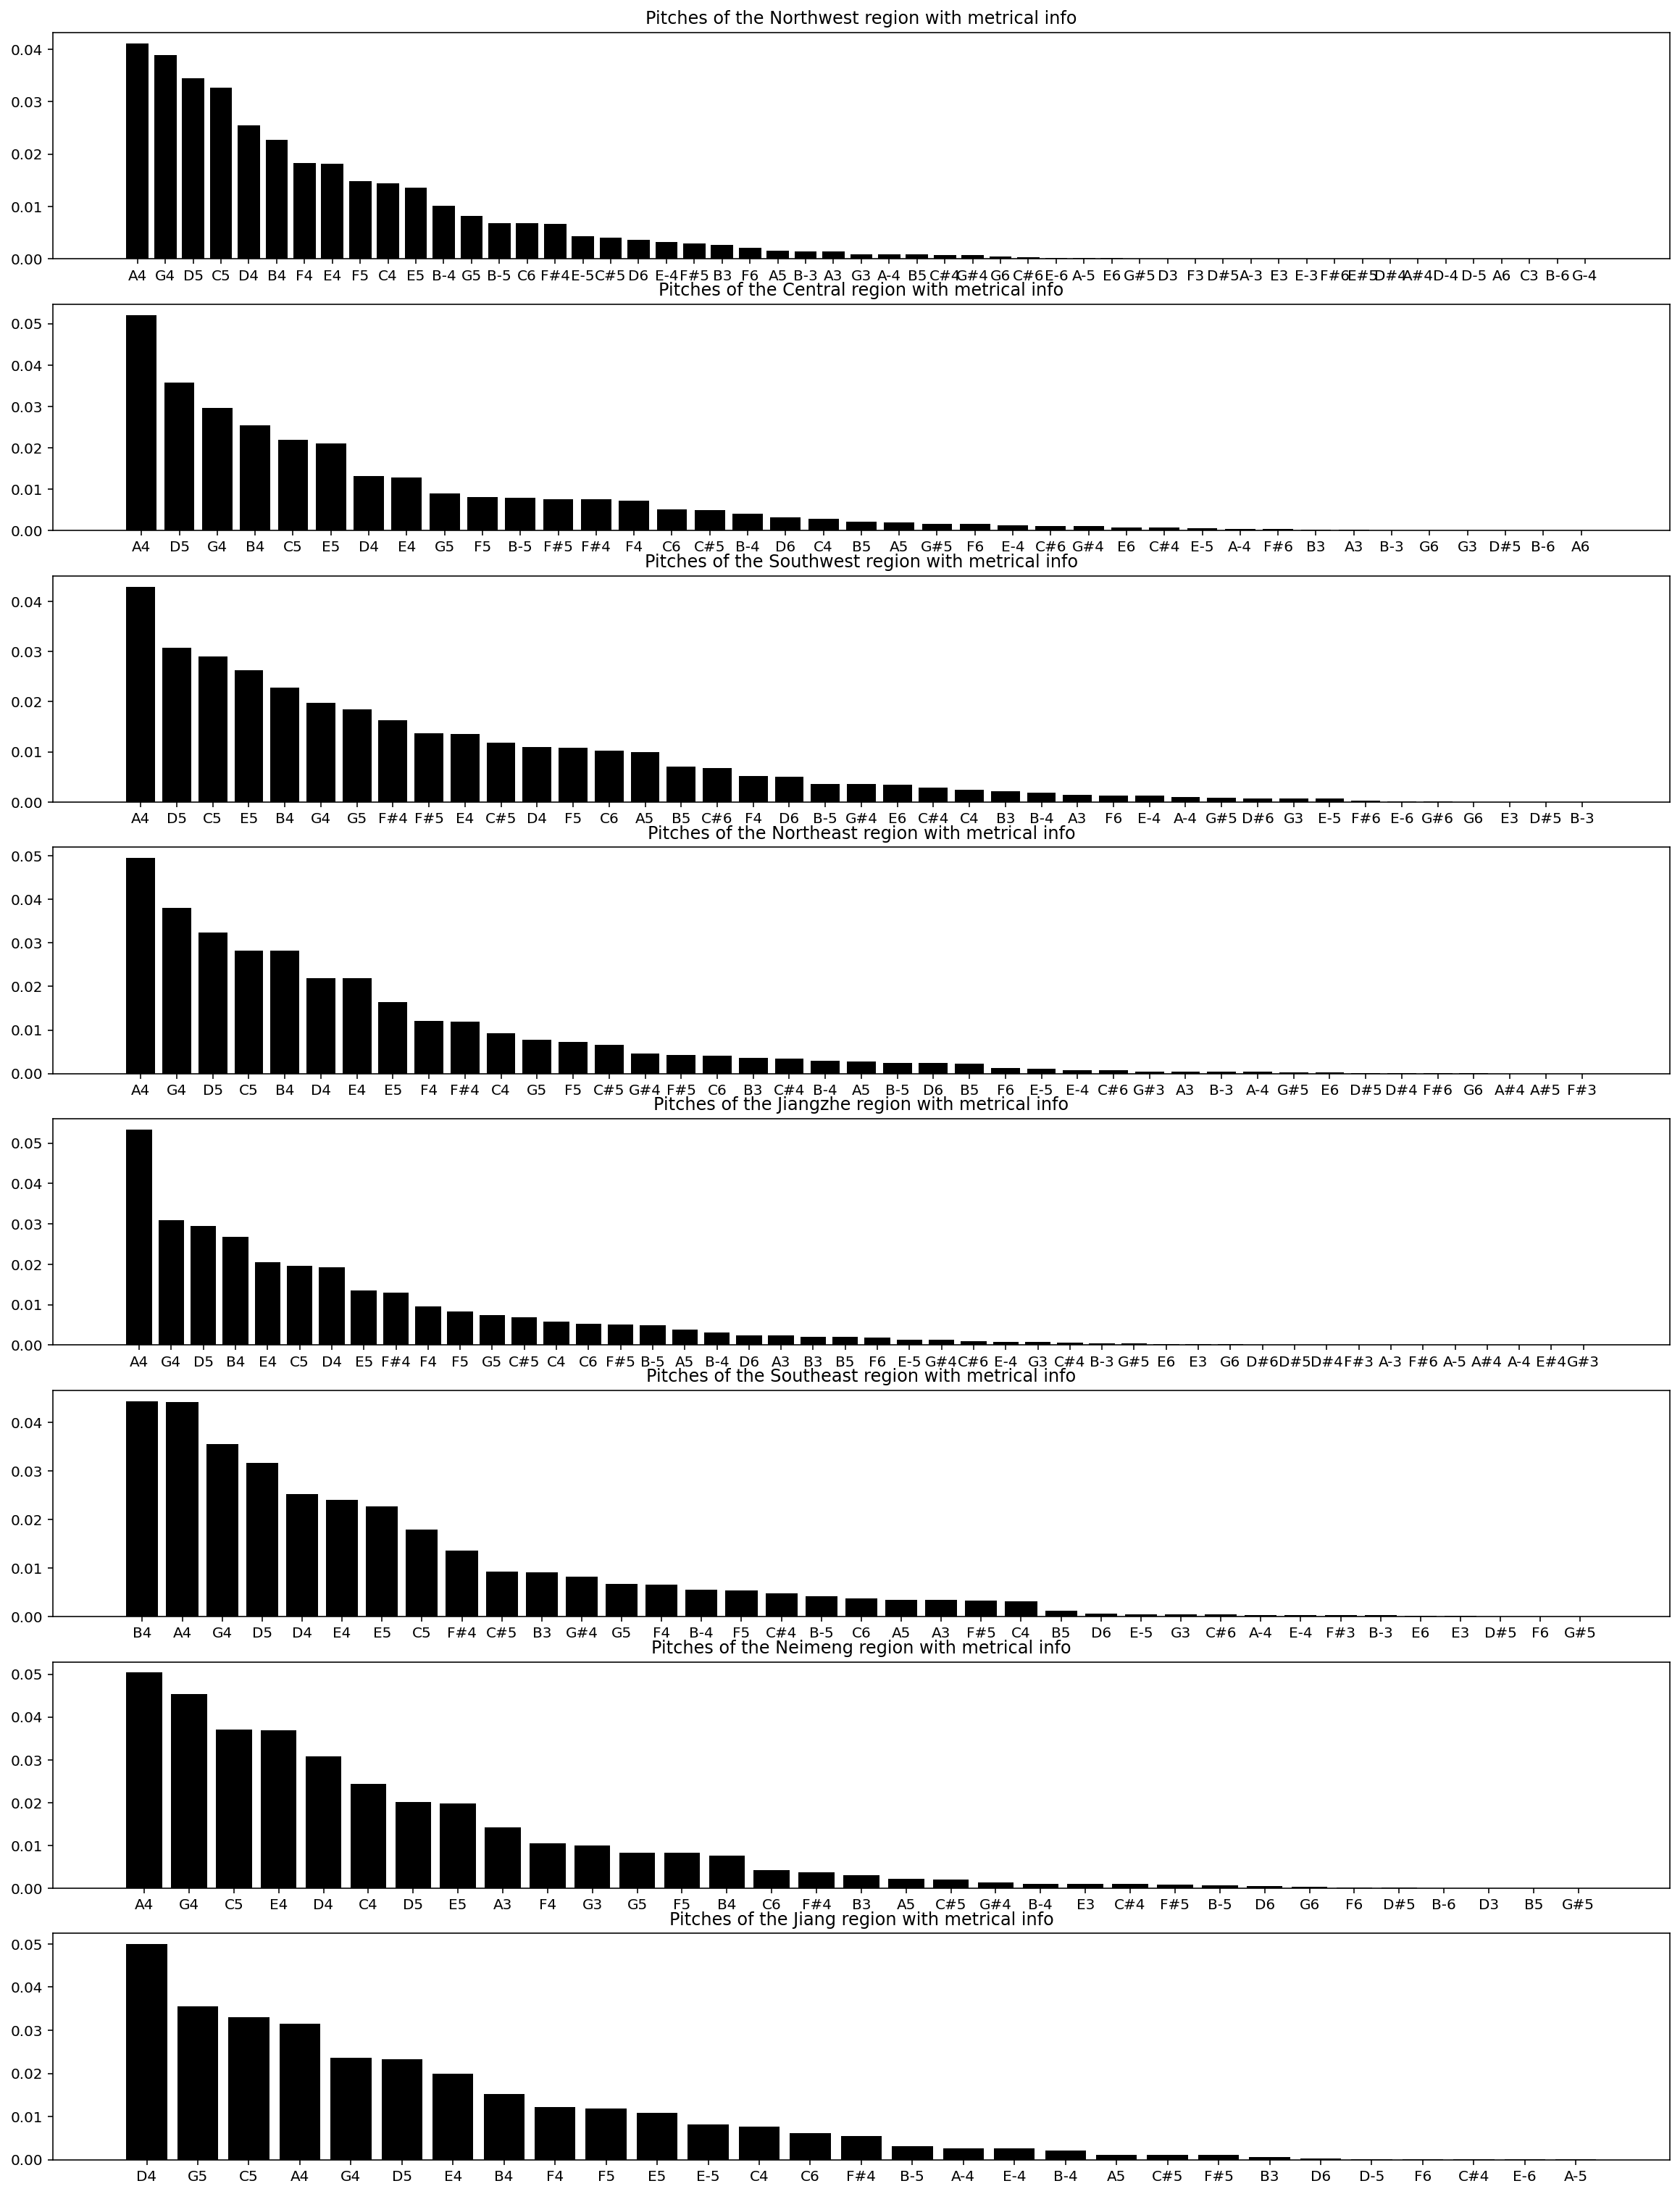

In [268]:
plot_region_stat_met(region_pitch_stat, figsize=(20,27), nrows=len(region_pitch_stat), ncols=1, title="Pitches of the {} region with metrical info")

### Scale Degree statistics (with metrical information)

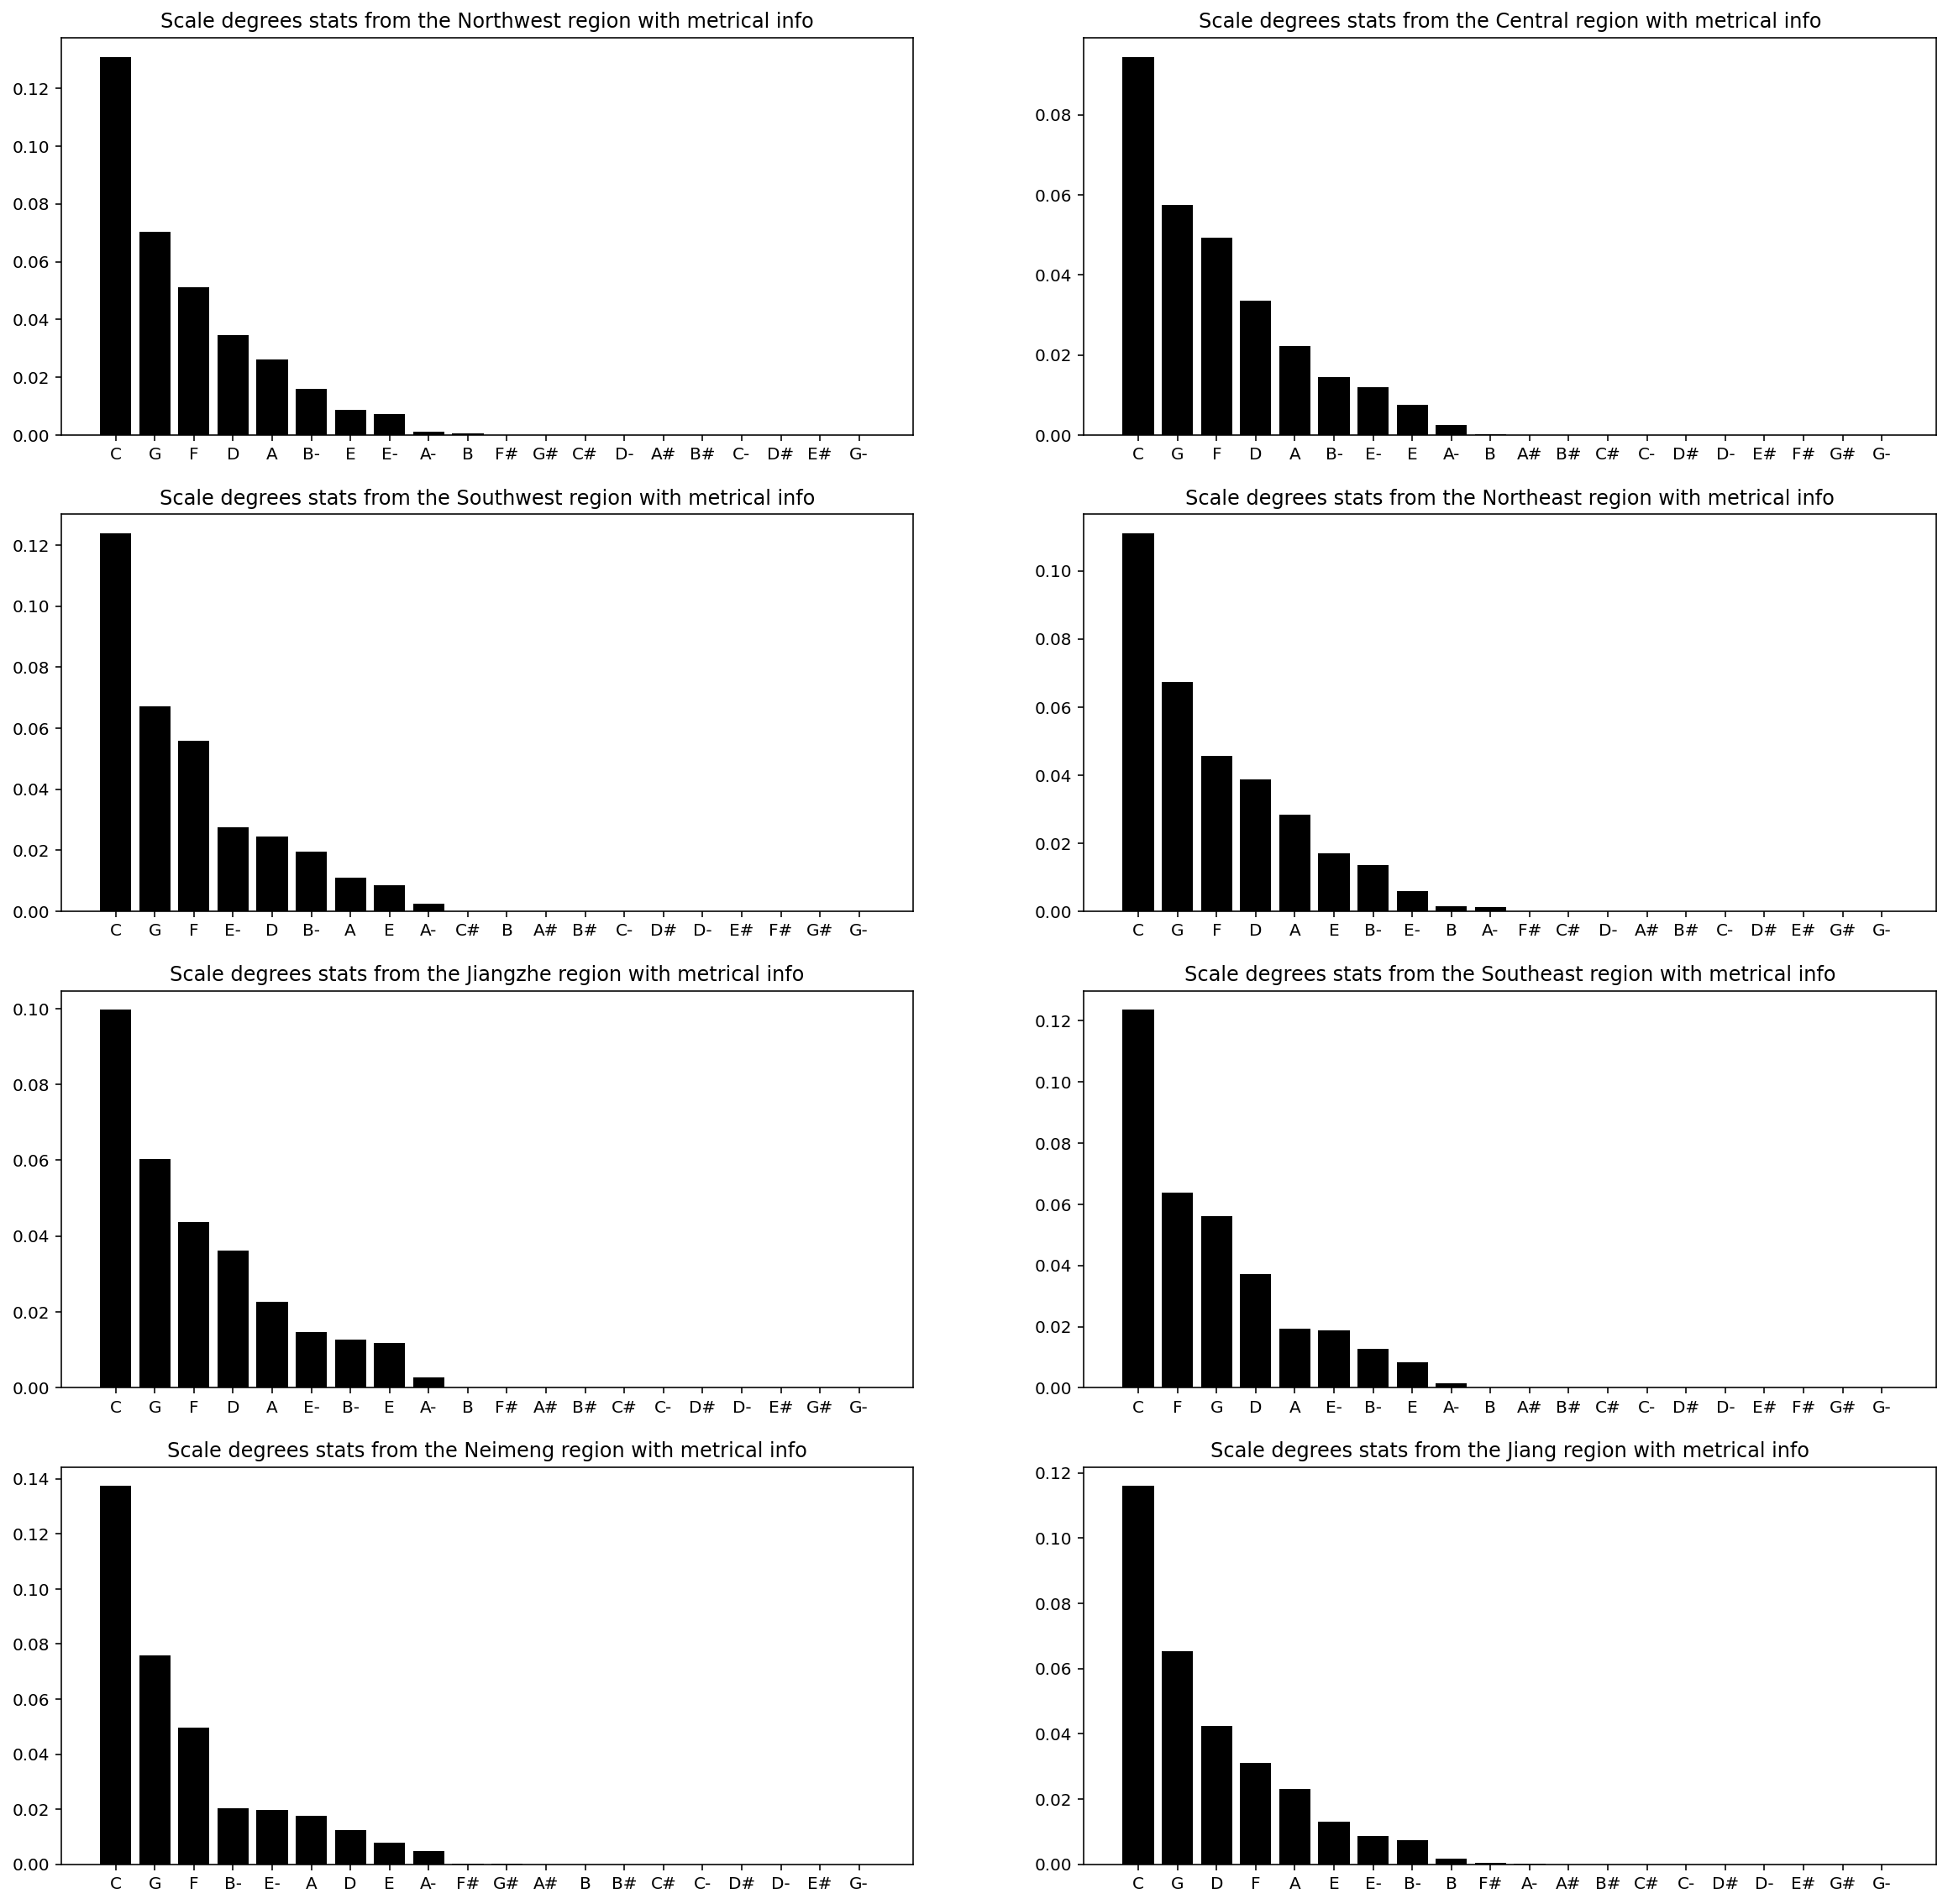

In [269]:
plot_region_stat_met(region_scaledegrees_stat, pitchclasses_defcount, title="Scale degrees stats from the {} region with metrical info", nrows=4, ncols=2, figsize=(20,20))

# Transitions landing on the beat

In [197]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for i in range(len(row["pitchclasses"])):
        if prev_pitchclass is not None:
            if math.isnan(row["durations"][i]) or math.isnan(row["beat_strengths"][i]):
                continue
            if prev_pitchclass not in pitchclass_transition[region]:
                pitchclass_transition[region][prev_pitchclass] = {}
            if row["pitchclasses"][i] not in  pitchclass_transition[region][prev_pitchclass]:
                pitchclass_transition[region][prev_pitchclass][row["pitchclasses"][i]] = row["durations"][i] * row["beat_strengths"][i]
            else:
                pitchclass_transition[region][prev_pitchclass][row["pitchclasses"][i]] += row["durations"][i] * row["beat_strengths"][i]
        prev_pitchclass = row["pitchclasses"][i]

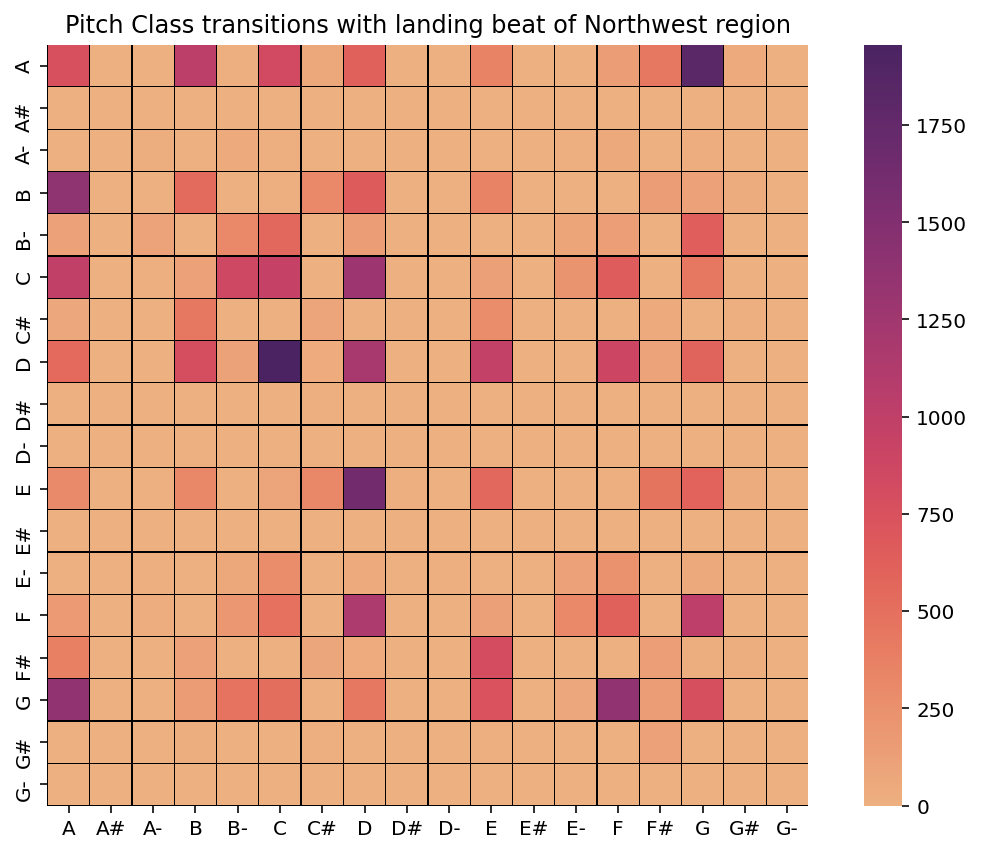

----------------------------------------------------------------------------------------------------


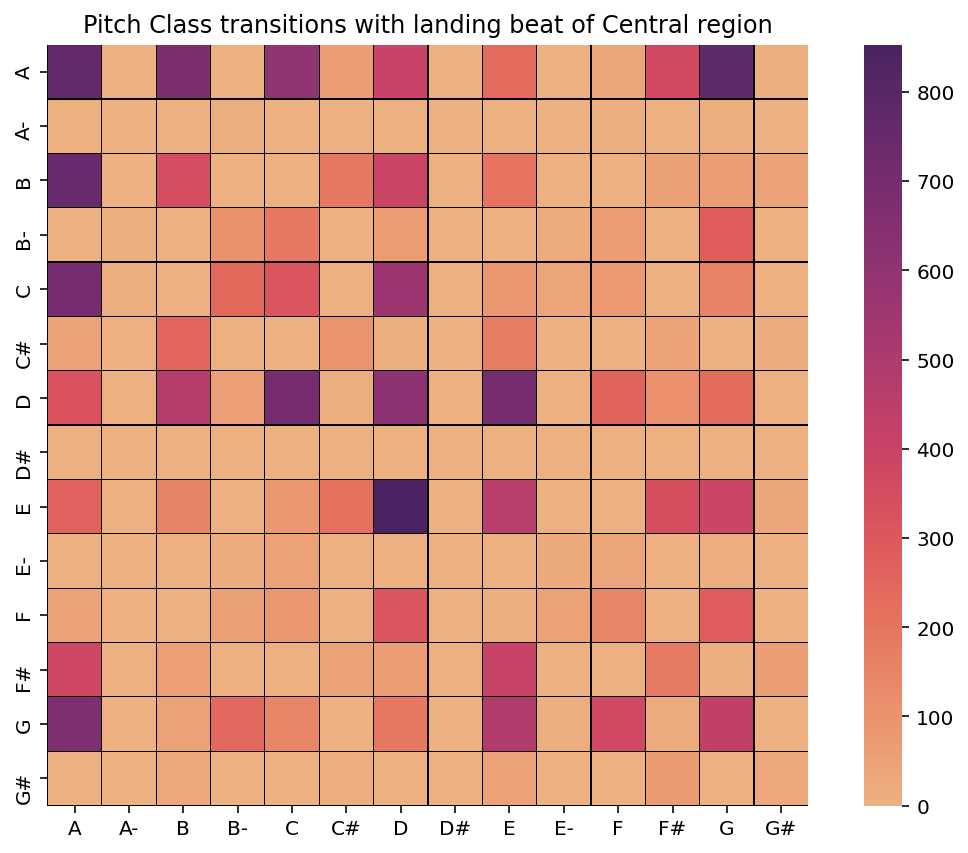

----------------------------------------------------------------------------------------------------


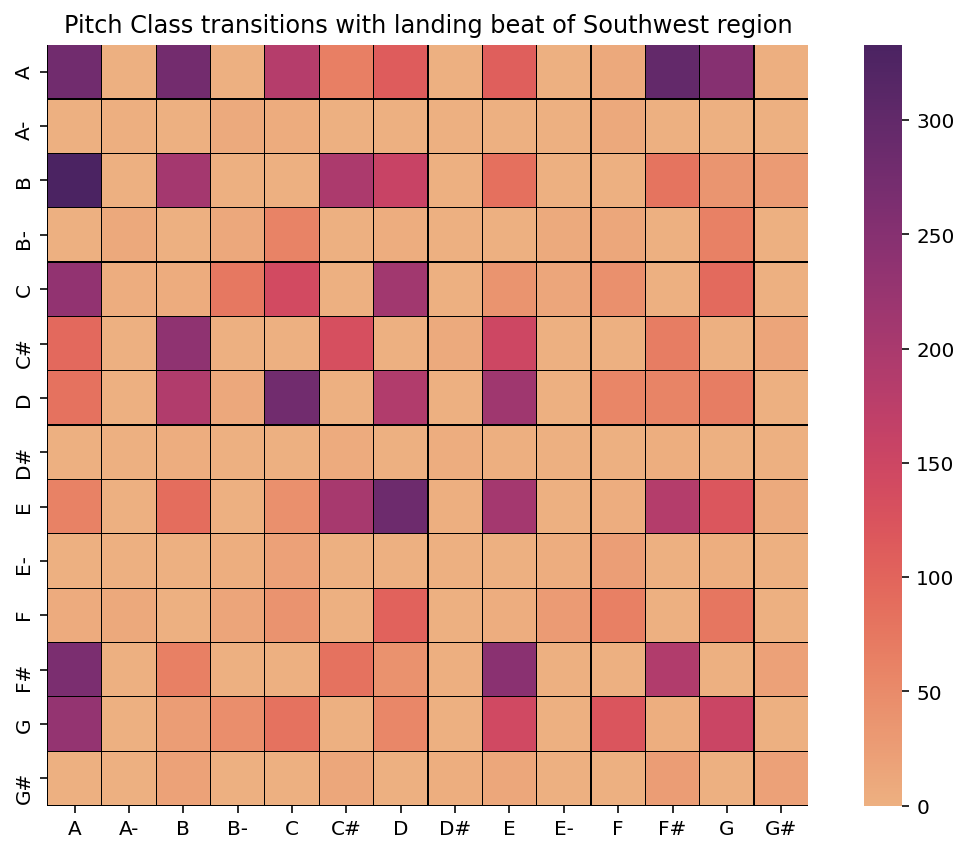

----------------------------------------------------------------------------------------------------


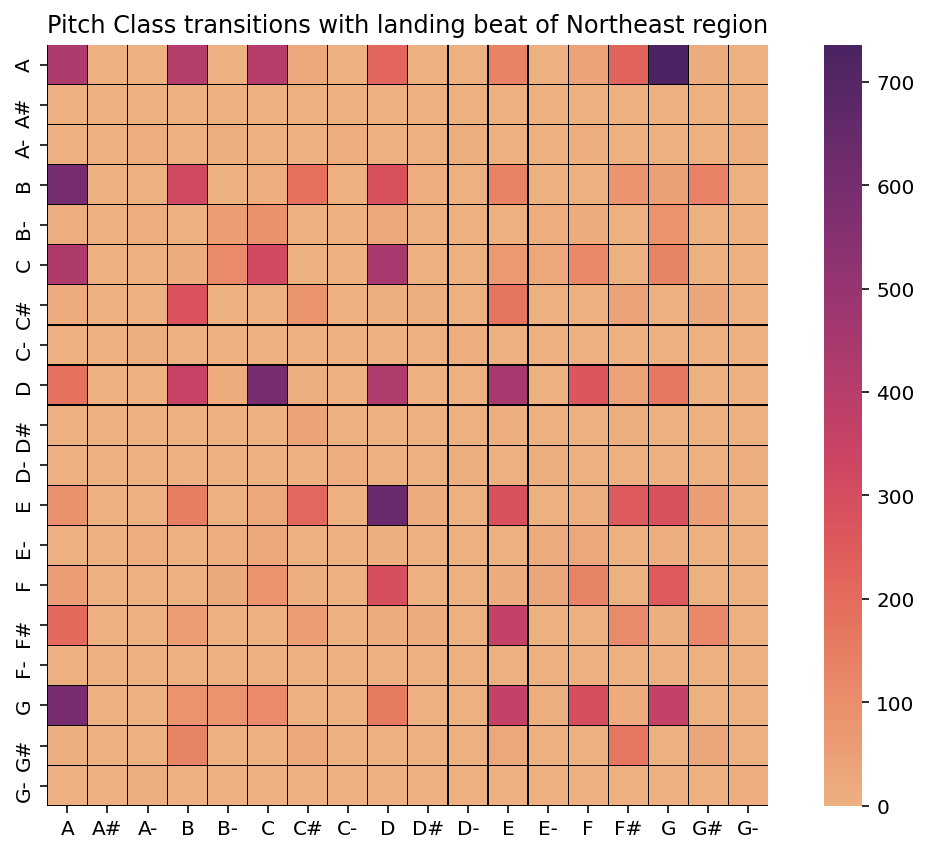

----------------------------------------------------------------------------------------------------


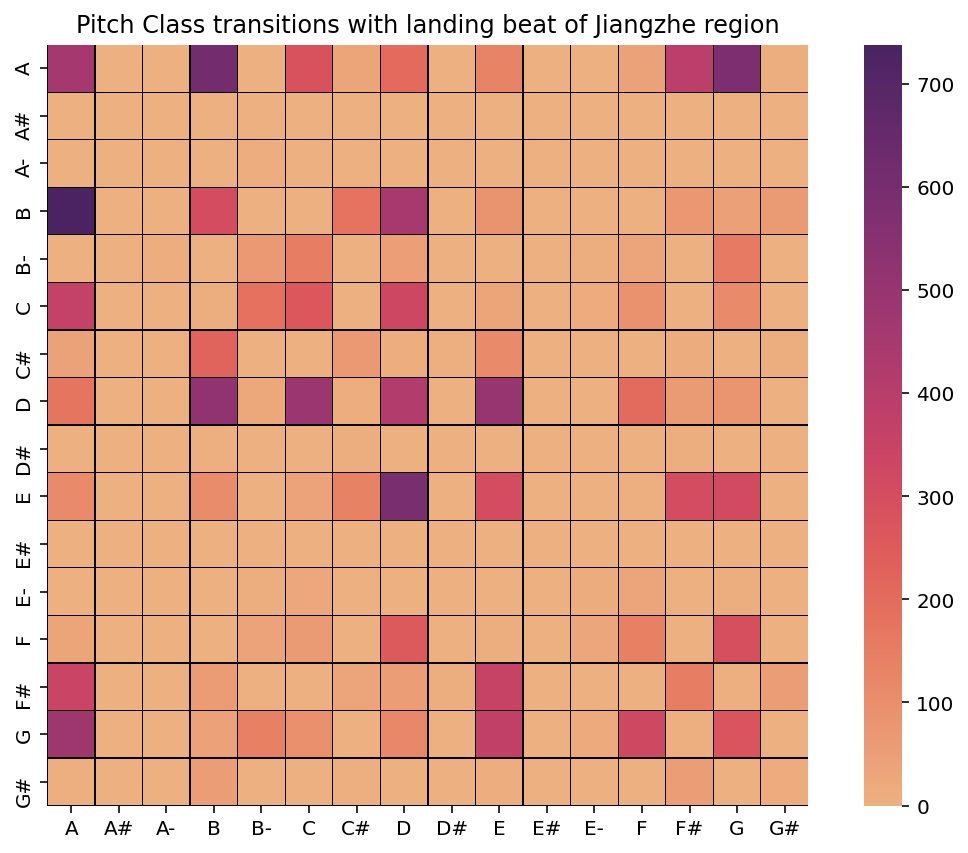

----------------------------------------------------------------------------------------------------


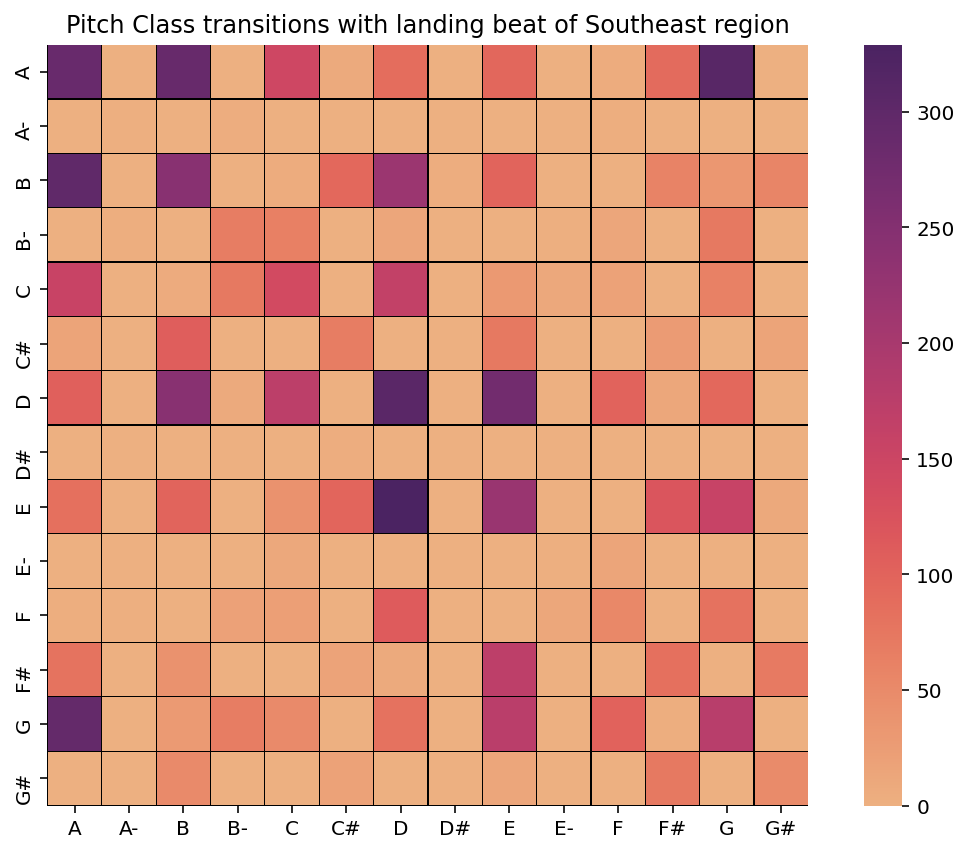

----------------------------------------------------------------------------------------------------


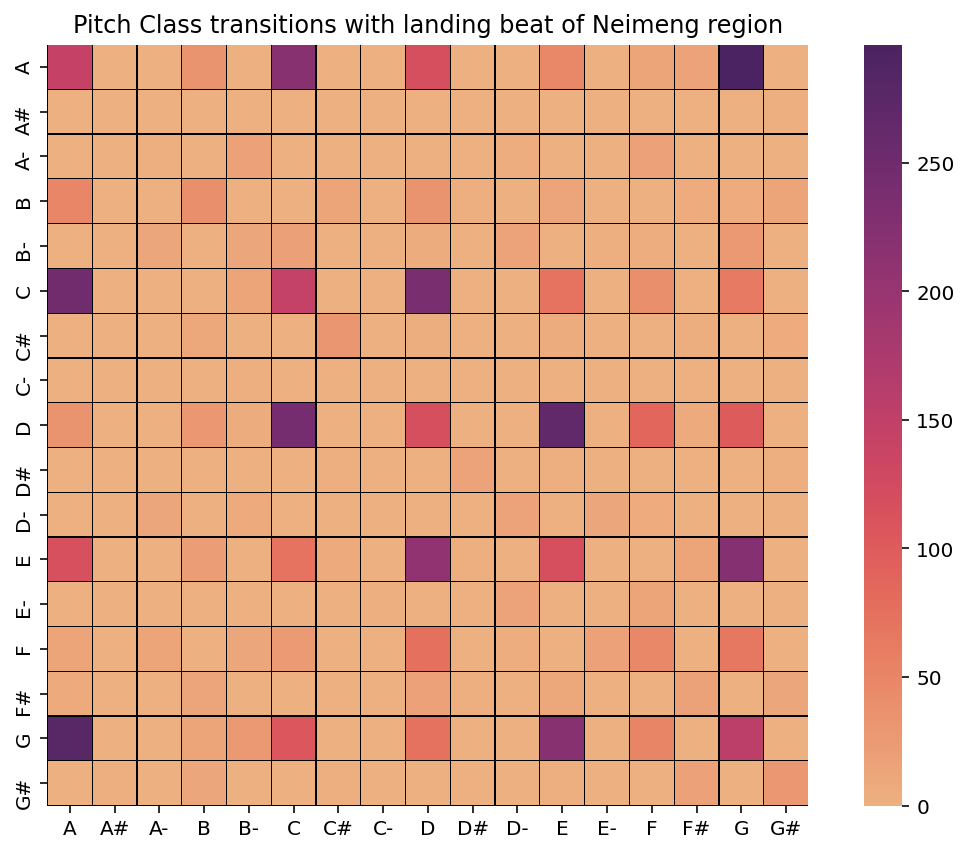

----------------------------------------------------------------------------------------------------


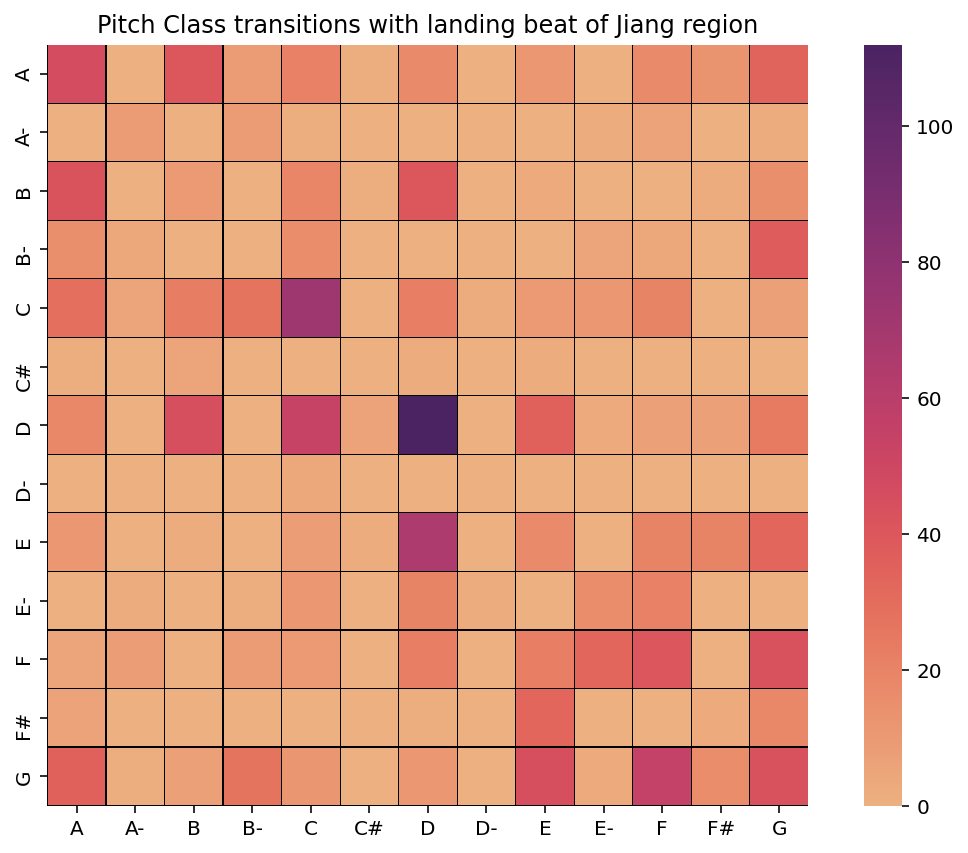

----------------------------------------------------------------------------------------------------


In [270]:
plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transitions with landing beat of {} region".format(gloc))
    plt.show()
    
    print("--"*50)

In [199]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for i in range(len(row["pitchclasses"])):
        if prev_pitchclass is not None:
            if math.isnan(row["durations"][i-1]) or math.isnan(row["beat_strengths"][i-1]):
                continue
            if prev_pitchclass not in pitchclass_transition[region]:
                pitchclass_transition[region][prev_pitchclass] = {}
            if row["pitchclasses"][i] not in  pitchclass_transition[region][prev_pitchclass]:
                pitchclass_transition[region][prev_pitchclass][row["pitchclasses"][i]] = row["durations"][i-1] * row["beat_strengths"][i-1]
            else:
                pitchclass_transition[region][prev_pitchclass][row["pitchclasses"][i]] += row["durations"][i-1] * row["beat_strengths"][i-1]
        prev_pitchclass = row["pitchclasses"][i]

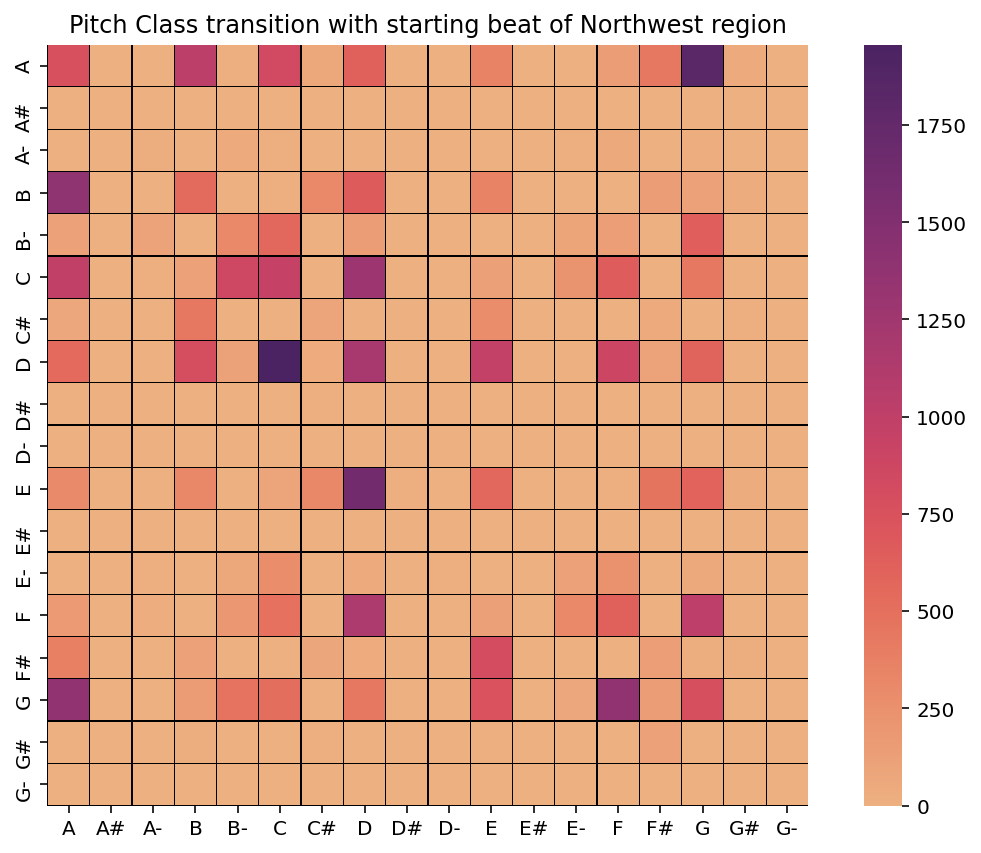

----------------------------------------------------------------------------------------------------


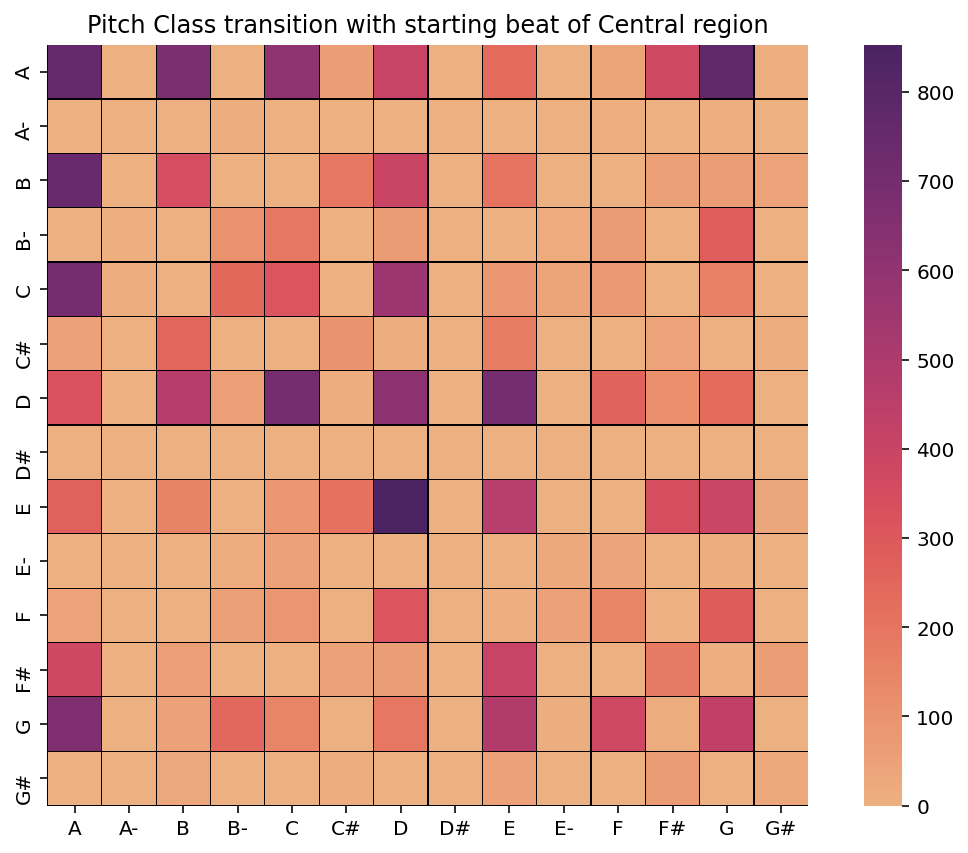

----------------------------------------------------------------------------------------------------


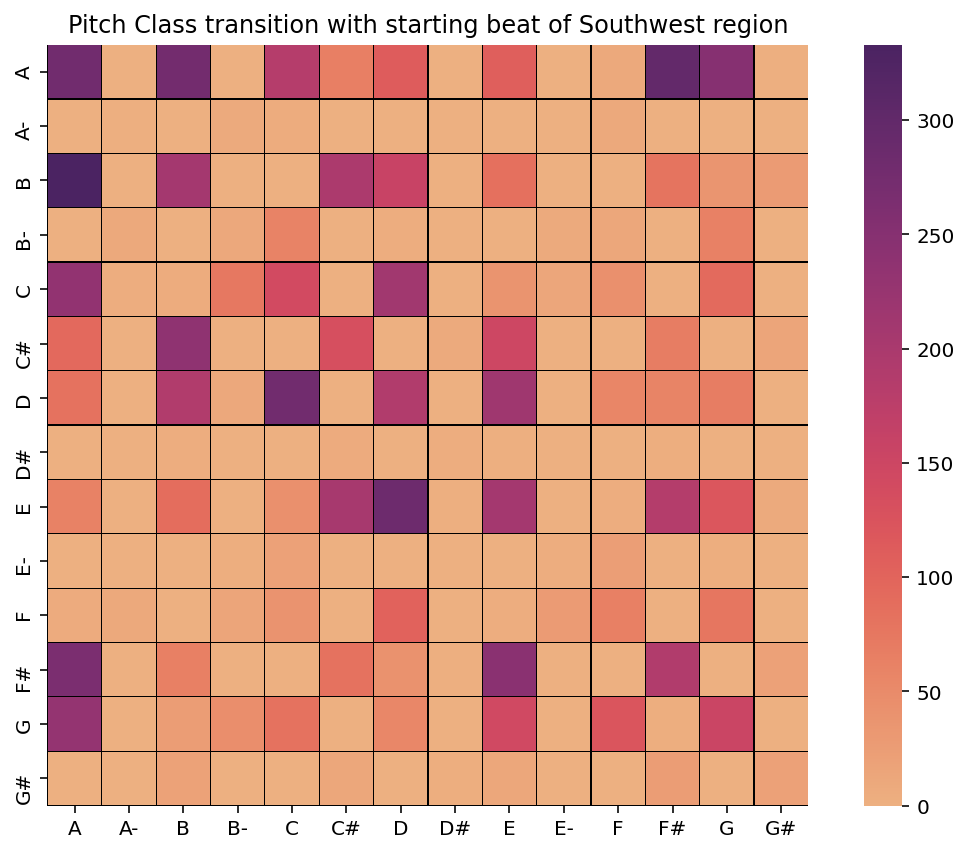

----------------------------------------------------------------------------------------------------


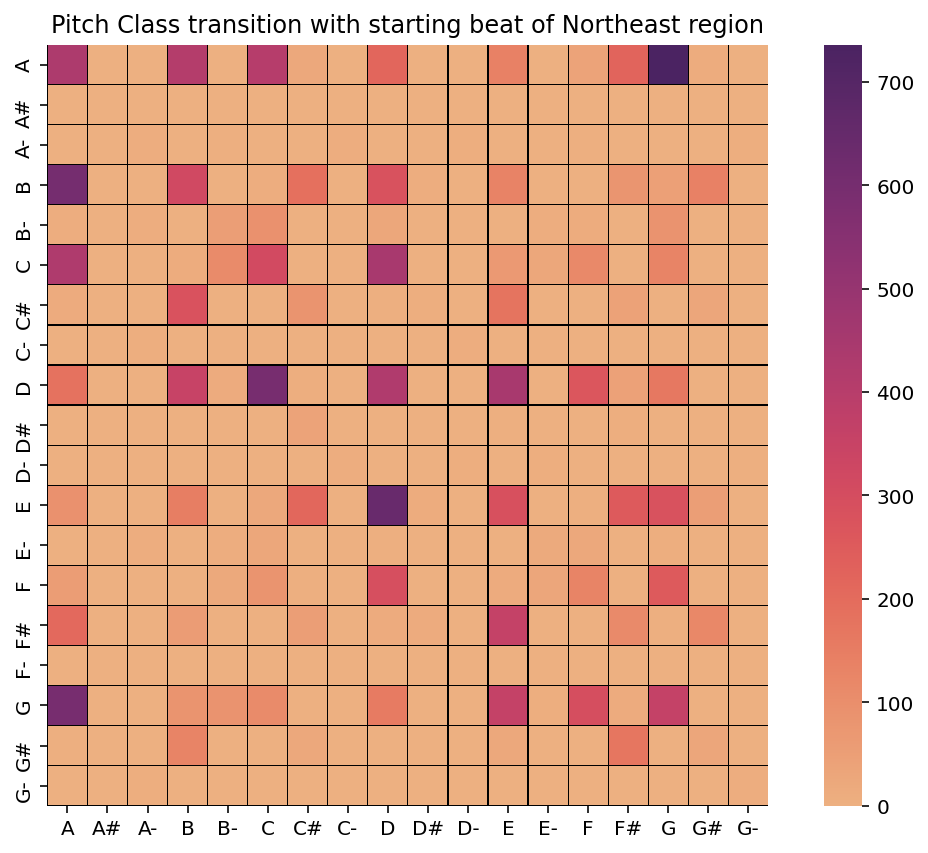

----------------------------------------------------------------------------------------------------


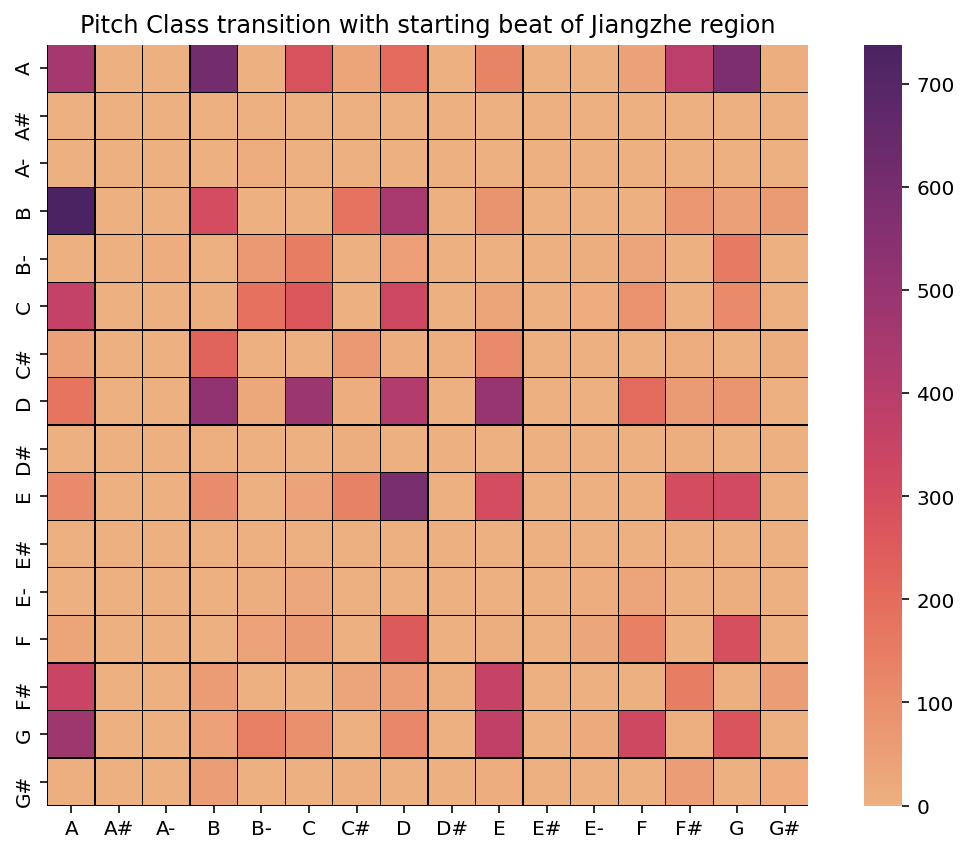

----------------------------------------------------------------------------------------------------


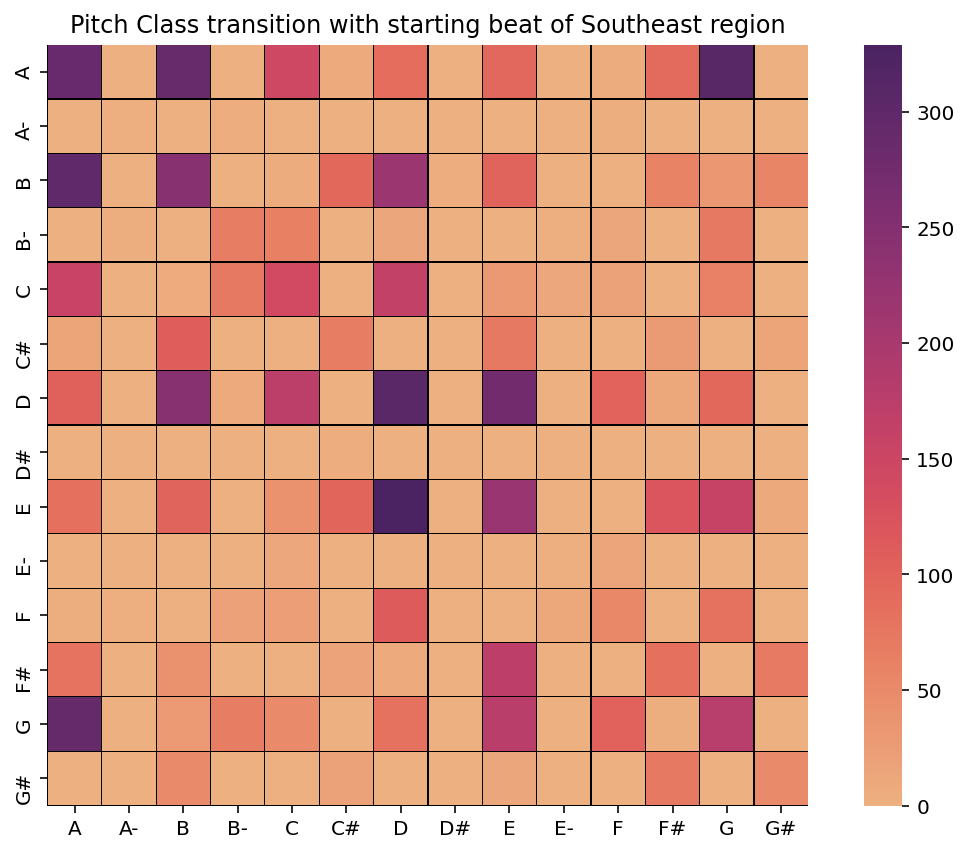

----------------------------------------------------------------------------------------------------


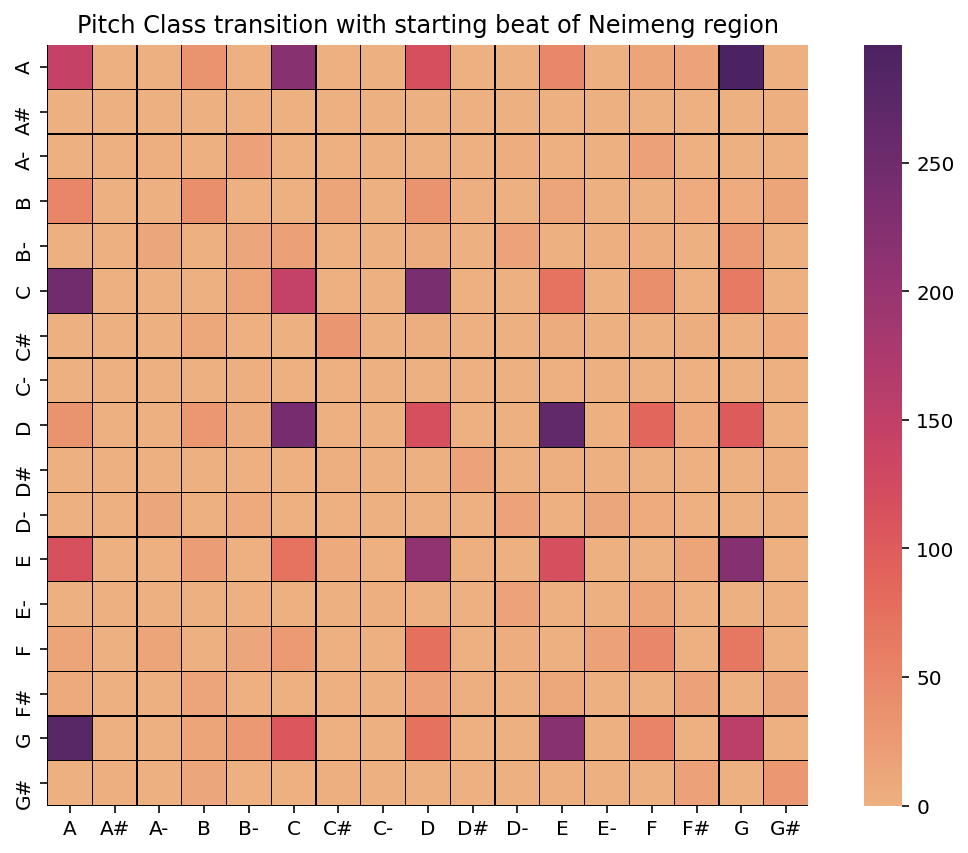

----------------------------------------------------------------------------------------------------


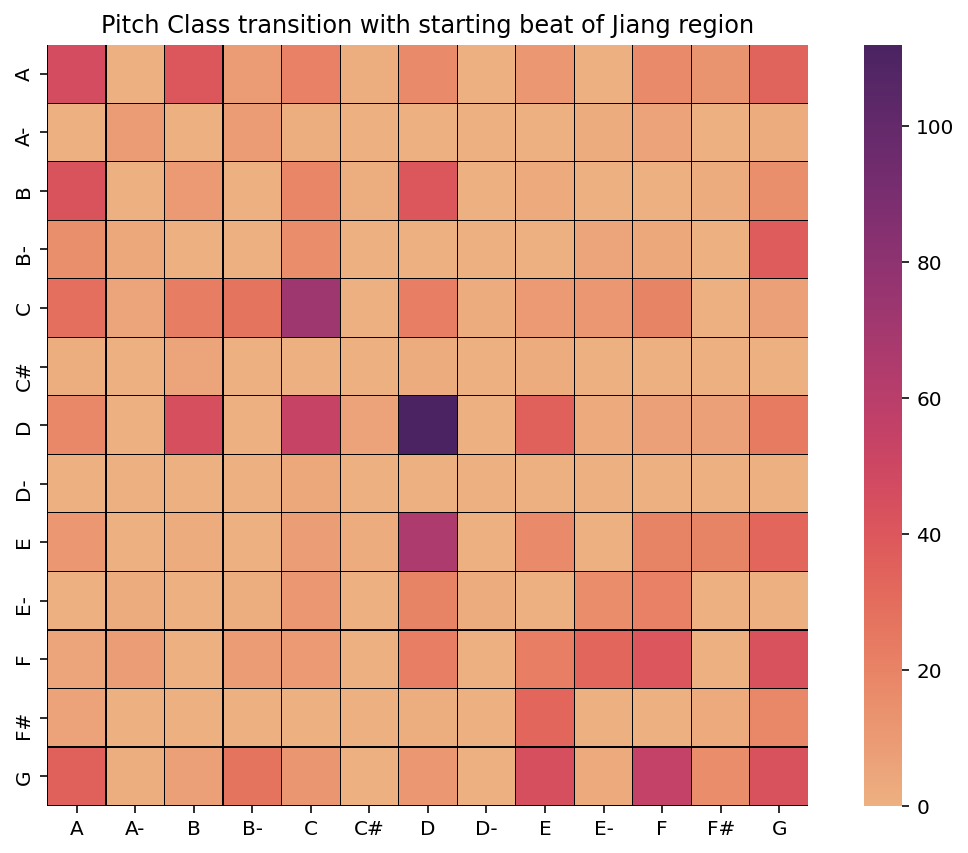

----------------------------------------------------------------------------------------------------


In [271]:
plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transition with starting beat of {} region".format(gloc))
    plt.show()
    
    print("--"*50)

# Transitions starting on the beat

### Intervals (with metrical information)

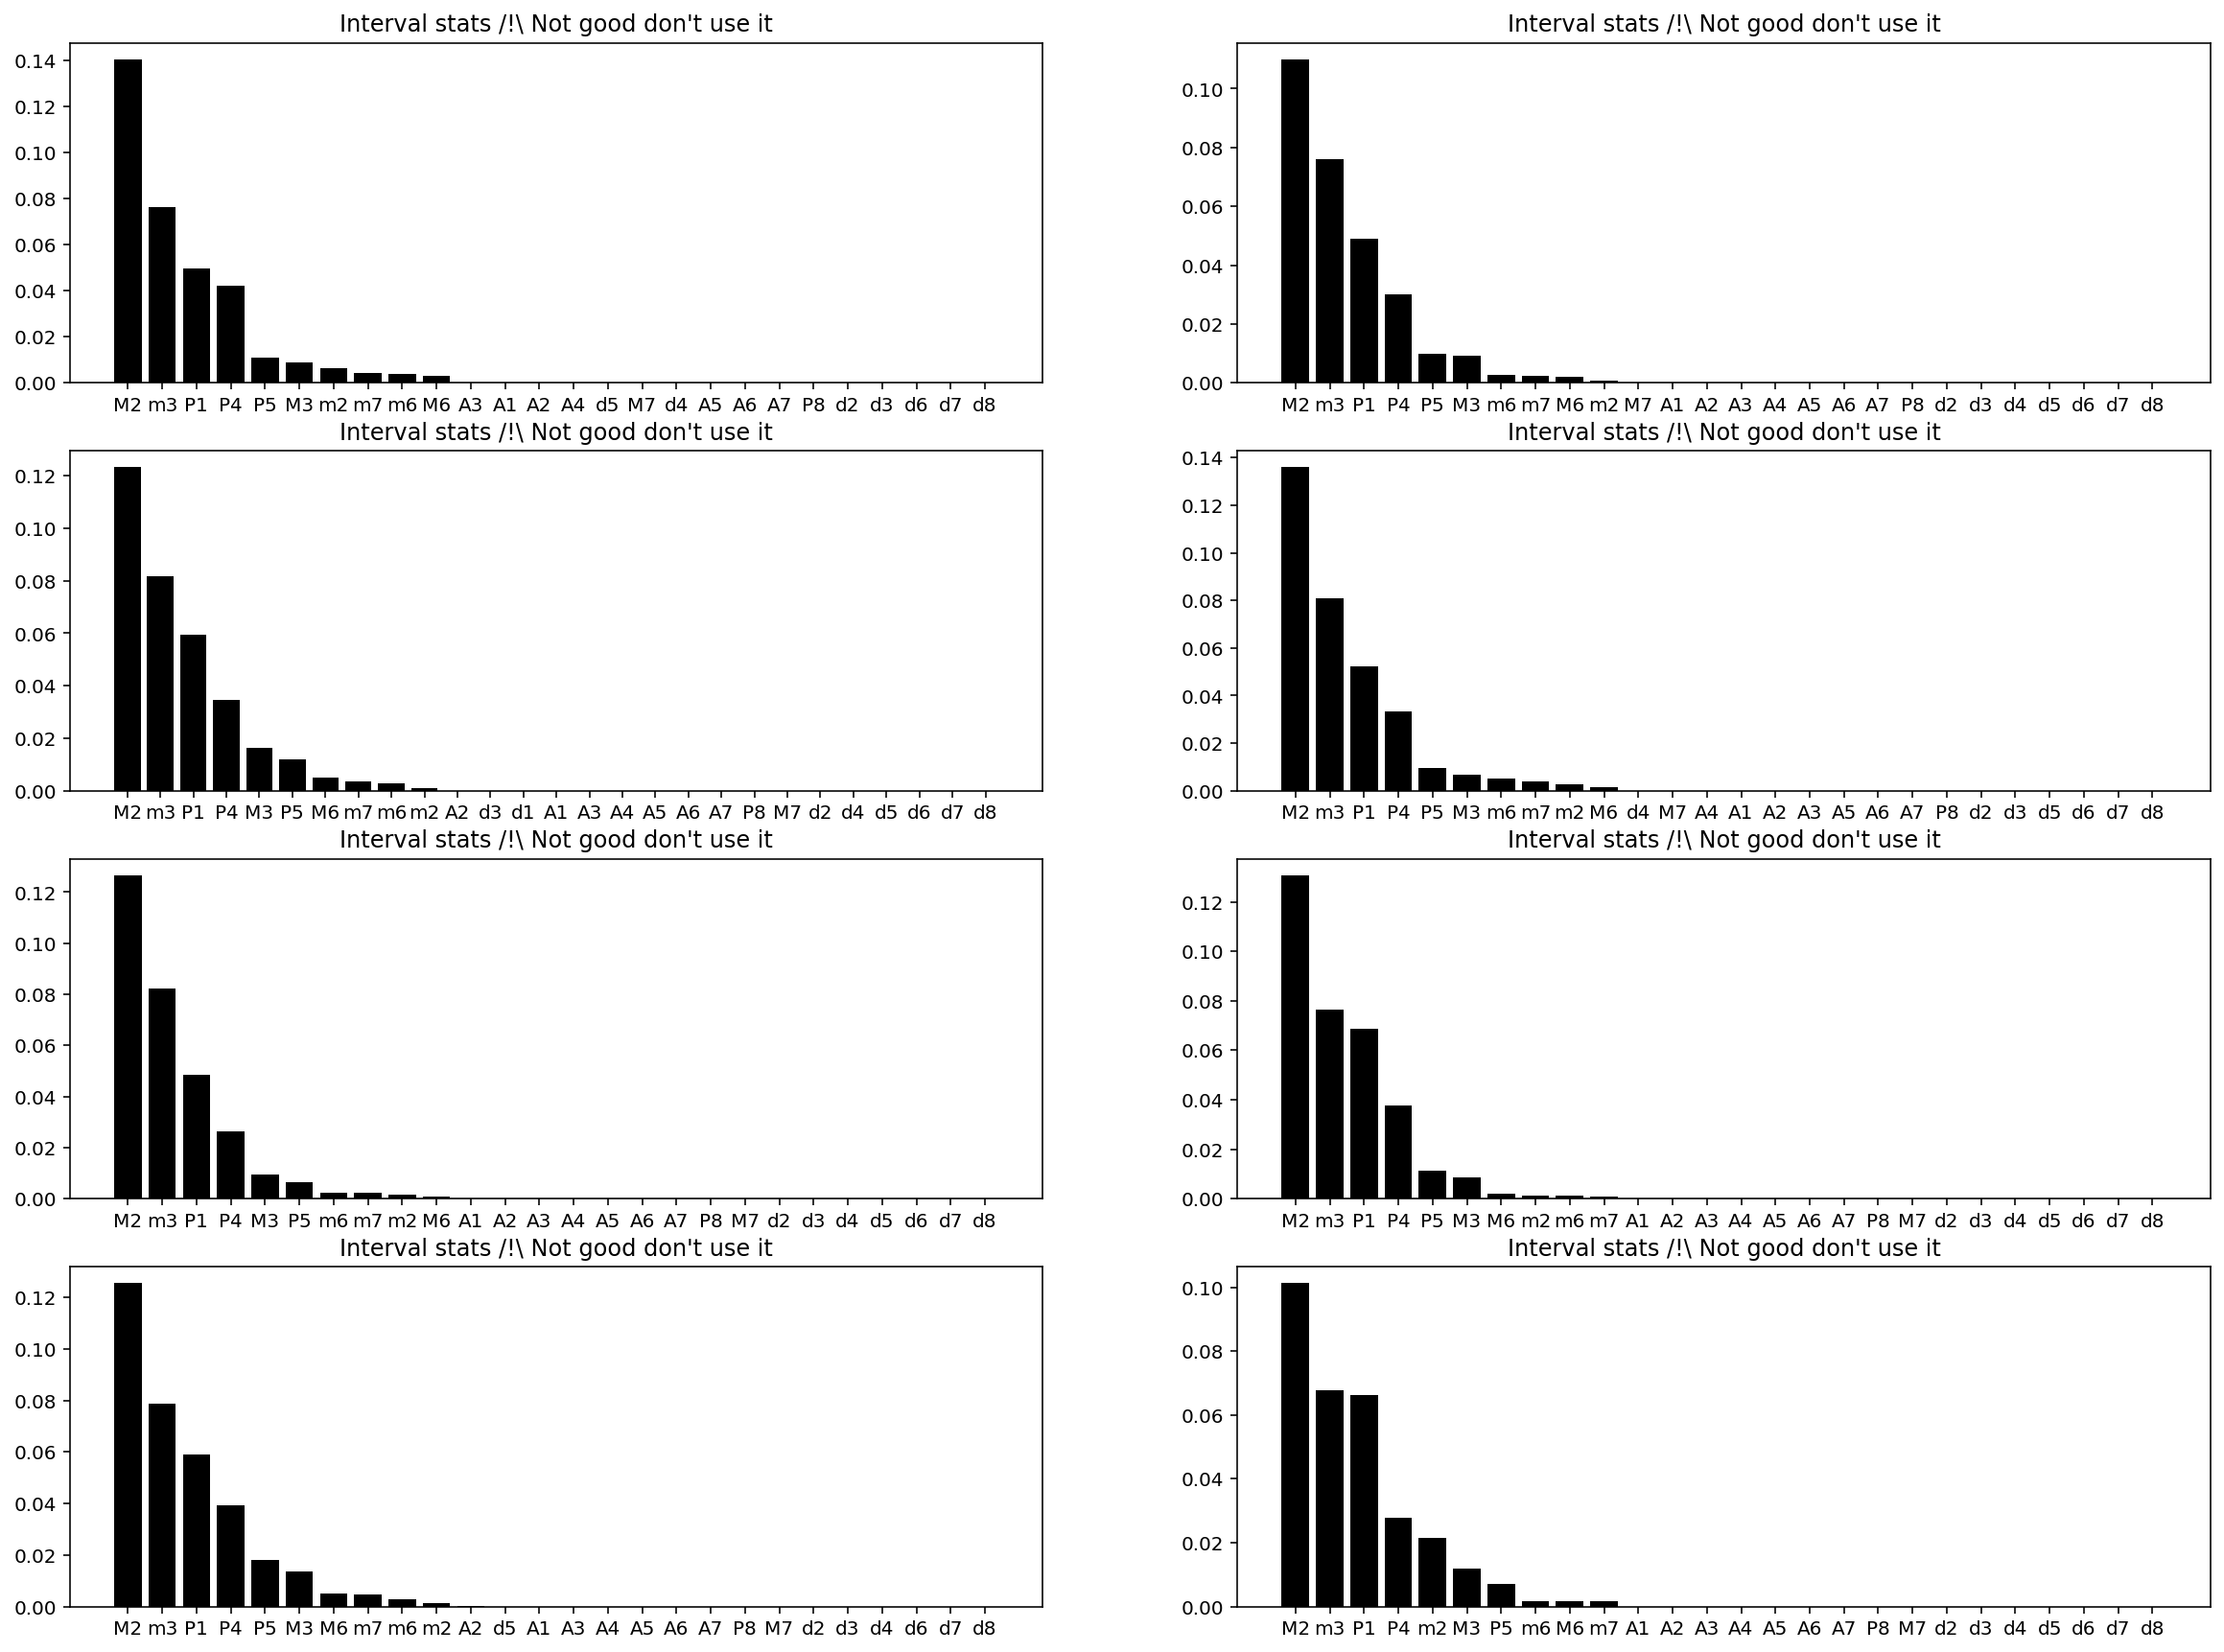

In [272]:
plot_region_stat_met(region_intervals_stat, intervals_defcount, nrows=4, ncols=2, figsize=(20,15), title="Interval stats /!\ Not good don't use it")

# Flexibity (entropy)

In [273]:
pitchclass_transition = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for pitchclass in row["pitchclasses"]:
        if prev_pitchclass is not None:
            if prev_pitchclass not in pitchclass_transition[region]:
                pitchclass_transition[region][prev_pitchclass] = {}
            if pitchclass not in  pitchclass_transition[region][prev_pitchclass]:
                pitchclass_transition[region][prev_pitchclass][pitchclass] = 1
            else:
                pitchclass_transition[region][prev_pitchclass][pitchclass] += 1
        prev_pitchclass = pitchclass
        
pitchclass_transition_probability = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition.items():
    for start_note, transition in transitions.items():
        pitchclass_transition_probability[region][start_note] = {}
        for landing_note, count in transition.items():
            pitchclass_transition_probability[region][start_note][landing_note] = count/sum(transition.values())

In [274]:
entropies = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition_probability.items():
    for start_note, probabilities in transitions.items():
        entropies[region][start_note] = -sum([p*math.log2(p) for p in probabilities.values()])

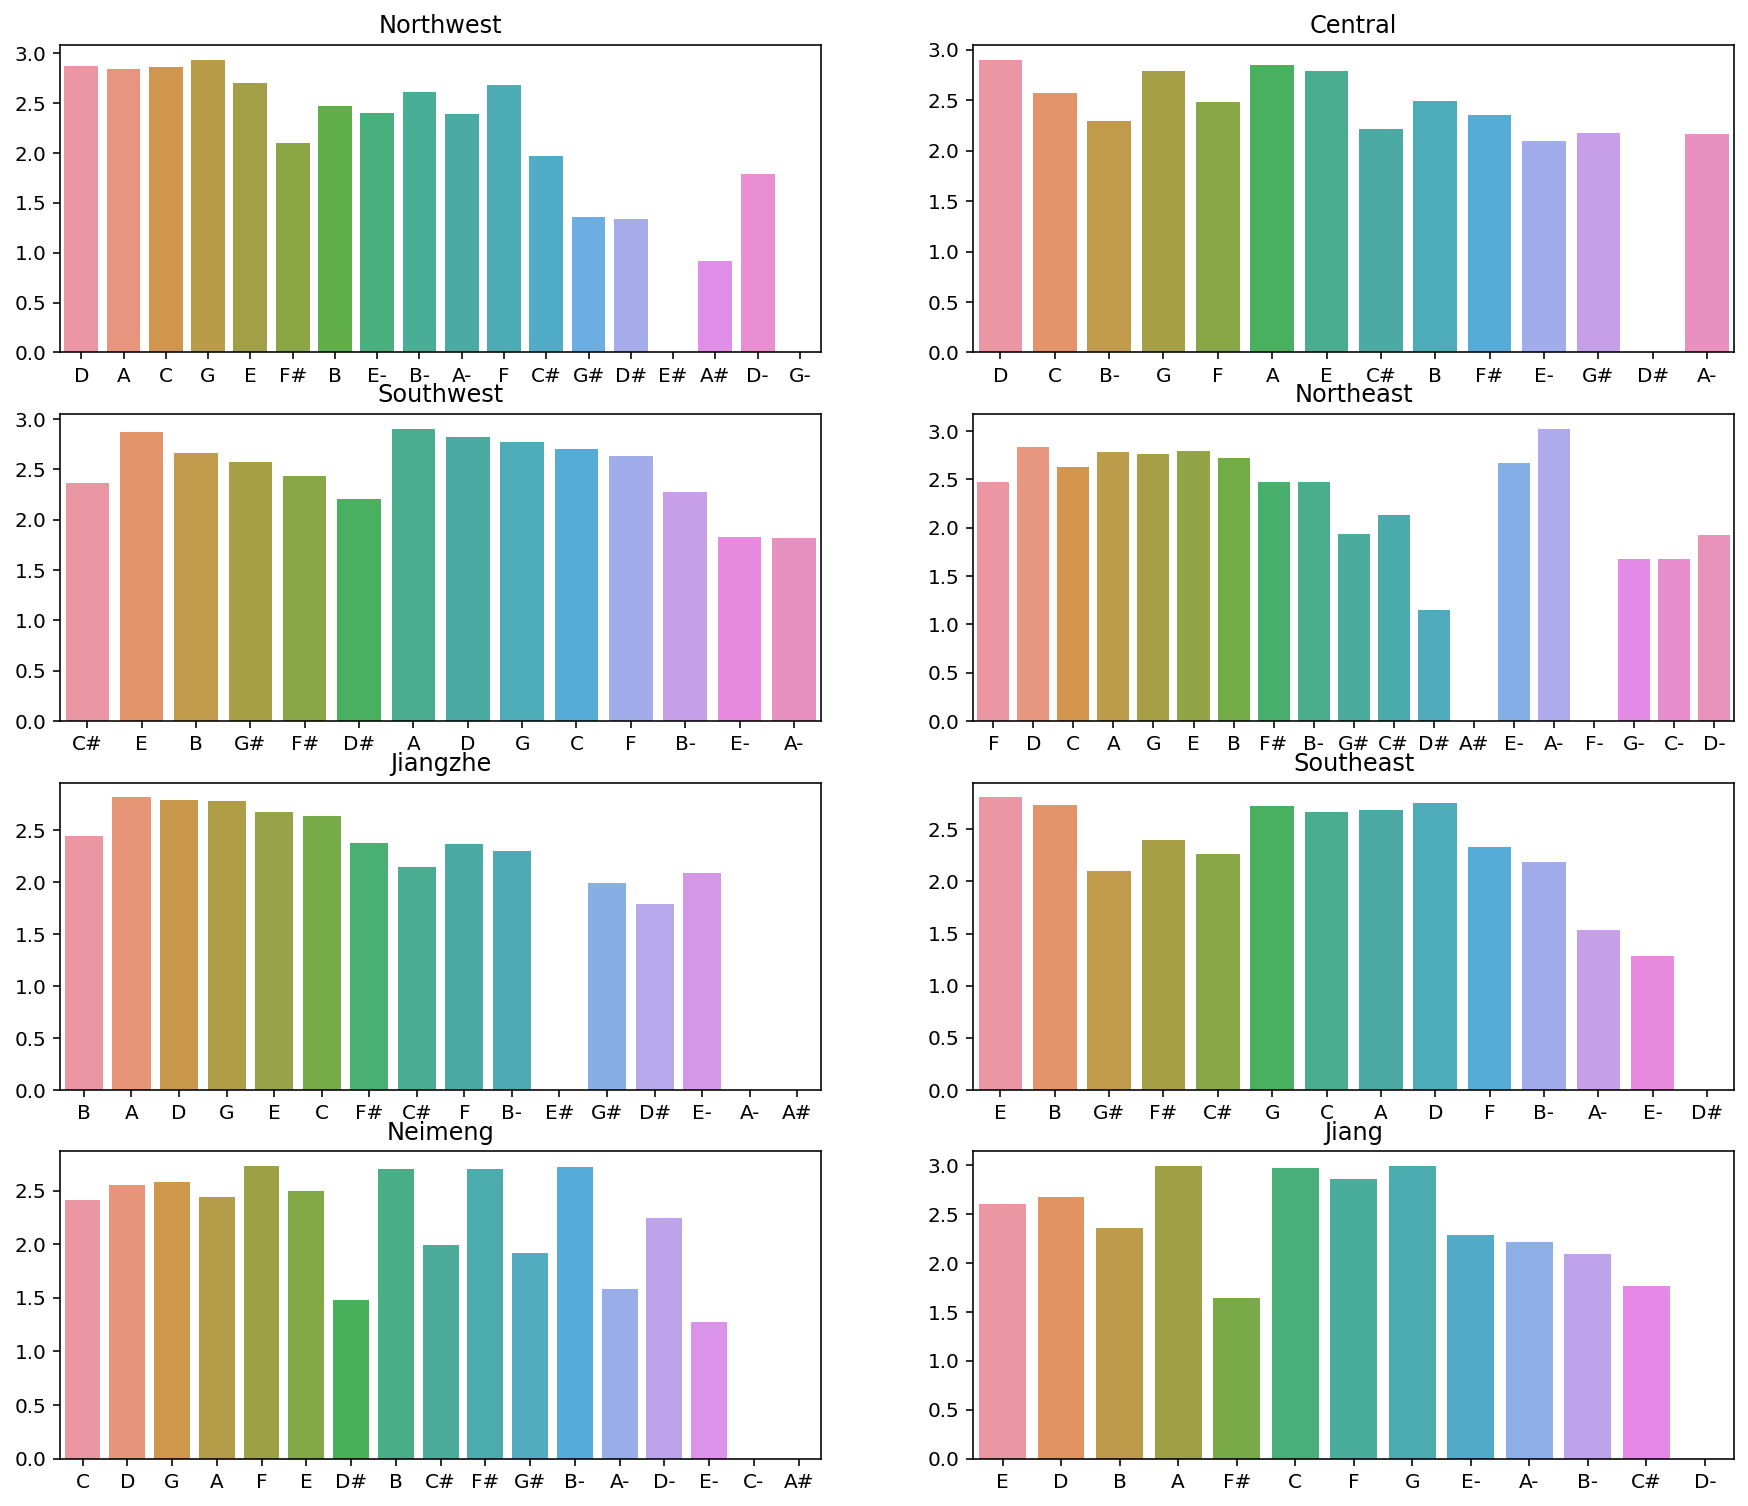

In [275]:
plt.rcParams["figure.figsize"] = (15, 13)
colormap = sns.color_palette("flare", as_cmap=True)
fig, axarr = plt.subplots(4, 2)
for gloc, ax in zip(geo_divisions, axarr.flat):
    ax.set_title(gloc)
    sns.barplot(x=list(entropies[gloc].keys()), y=list(entropies[gloc].values()), ax=ax)